In [ ]:
%pylab inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tf_memory_limit
from zinb import ZINB

import seaborn as sns

import matplotlib
matplotlib.use('TkAgg')  # noqa

from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.optimizers import RMSprop, SGD
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

d = np.load("embedding_files/chr1_40894464_41025536.npz")
embeds = d['embeddings']
num_inputs = embeds.shape[-1]

counts = {}
count_data = np.load('/mnt/DATA2/thouis/GM12878/chr1_to_chr10_counts.npz')
for k in count_data.keys():
    counts[k] = count_data[k]
num_outputs = count_data['chr1'].shape[1]

(num_inputs, num_outputs), count_data_chr1.shape

Populating the interactive namespace from numpy and matplotlib


/home/thouis/VENV/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [7]:
# from predict_basenji_chr1.py
seq_input_size = 131072
seq_half = seq_input_size // 2

import glob
import random
embed_files = glob.glob('embedding_files/chr*.npz')

def datagen(infiles, counts):
    assert len(infiles) > 1
    infiles = [f for f in infiles]  # copy for shuffling
    halfstep = False
    while True:
        random.shuffle(infiles)
        for f in infiles:
            embed = np.load(f)['embeddings']
            chr, start, end = f.split('/')[-1].split('_')
            start = int(start)
            end = int(end[:-4])  # trim .npz
            if not halfstep:
                embed = embed[0, ...]
            else:
                embed = embed[1, ...]
                start += seq_half
                end += seq_half
            halfstep = random.choice([True, False])
            start128 = start // 128
            end128 = end // 128
            subcounts = counts[chr][start128:end128, :]
            smoothed = 0.5 * subcounts
            smoothed[1:, :] += 0.25 * subcounts[:-1, :]
            smoothed[:-1, :] += 0.25 * subcounts[1:, :]
            yield embed, smoothed

def chrnum(f):
    chr = f.split('/')[-1].split('_')[0]
    return int(chr[3:])

def traingen():
    chrfiles = [f for f in embed_files if chrnum(f) < 8]
    for a, b in datagen(chrfiles, counts):
        yield a, b

def valgen():
    chrfiles = [f for f in embed_files if chrnum(f) >= 8]
    for a, b in datagen(chrfiles, counts):
        yield a, b

a, b = next(traingen())
a.shape, b.shape

((1024, 717), (1024, 344))

In [165]:
# MODEL
inputs = Input(shape=(num_inputs,))
dropped = Dropout(0.5)(inputs)
expand = Dense(num_outputs * 3, activation = None)(dropped)
predictions = Dense(num_outputs, activation=tf.exp)(expand)
model = Model(inputs=inputs, outputs=predictions)

pi_layer = Dense(num_outputs, activation='sigmoid')
pi = pi_layer(expand)
zinb = ZINB(pi, theta_init=tf.zeros([1, num_outputs]))

model.layers[-1].trainable_weights.extend([zinb.theta_variable,
                                           *pi_layer.trainable_weights])



In [ ]:
from keras.optimizers import RMSprop, SGD, Adam


opt = RMSprop(lr=1e-5)
opt = SGD(lr=1e-3, momentum=0.9)
model.compile(optimizer=opt,
              loss=zinb.loss)  # zinb loss function

early_stop = EarlyStopping(monitor='val_loss', patience=100)
filepath="weights-{epoch:02d}-{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
losses = model.fit_generator(traingen(), steps_per_epoch=1000, epochs=2000,
                   callbacks=[early_stop, checkpoint],
                   validation_data=valgen(), validation_steps=400, verbose=2)


val_hist = losses.history['val_loss']
train_hist = losses.history['loss']

Epoch 1/2000
Epoch 00000: val_loss improved from inf to 1.93979, saving model to weights-00-1.940.hdf5
95s - loss: 2.4792 - val_loss: 1.9398
Epoch 2/2000
Epoch 00001: val_loss improved from 1.93979 to 1.84879, saving model to weights-01-1.849.hdf5
103s - loss: 2.0976 - val_loss: 1.8488
Epoch 3/2000
Epoch 00002: val_loss improved from 1.84879 to 1.82593, saving model to weights-02-1.826.hdf5
107s - loss: 1.9954 - val_loss: 1.8259
Epoch 4/2000
Epoch 00003: val_loss improved from 1.82593 to 1.77118, saving model to weights-03-1.771.hdf5
108s - loss: 1.9744 - val_loss: 1.7712
Epoch 5/2000
Epoch 00004: val_loss improved from 1.77118 to 1.76794, saving model to weights-04-1.768.hdf5
118s - loss: 1.9147 - val_loss: 1.7679
Epoch 6/2000
Epoch 00005: val_loss improved from 1.76794 to 1.73868, saving model to weights-05-1.739.hdf5
99s - loss: 1.9299 - val_loss: 1.7387
Epoch 7/2000
Epoch 00006: val_loss did not improve
98s - loss: 1.9141 - val_loss: 1.7430
Epoch 8/2000
Epoch 00007: val_loss improv

In [155]:
train_hist[:10]

[1.7684967417791486,
 1.7797533558309078,
 1.7888142464086414,
 1.7954626668542624,
 1.7839959416016937,
 1.8031786477789282,
 1.7884251243323088,
 1.7775699646398424,
 1.8158681159615517,
 1.7927107188105582]

In [37]:
model.load_weights('weights-73-1.506.hdf5')


In [129]:
a, b = next(valgen())
p = model.predict_on_batch(a)

(0, 40)

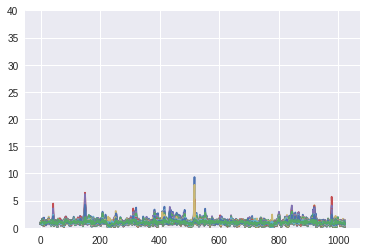

In [130]:
n = p.mean(axis=0, keepdims=True)
len(plot(p / n))
ylim(0, 40)

(0, 40)

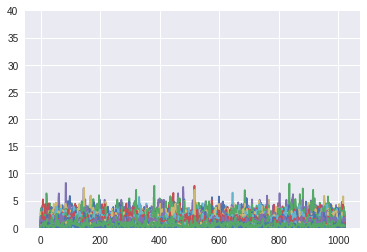

In [131]:
plot(b / n);
ylim(0, 40)

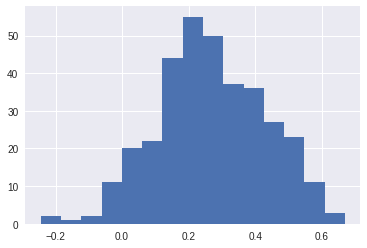

In [134]:
from scipy.stats import pearsonr, spearmanr

sub = 8
ps = p.cumsum(axis=0)
ps = ps[sub::sub] - ps[:-sub:sub]
bs = b.cumsum(axis=0)
bs = bs[sub::sub] - bs[:-sub:sub]

Rs = [pearsonr(ps[:, idx], bs[:, idx])[0] for idx in range(344)]
hist(Rs, 'auto');

In [63]:
(array(Rs) >0.8).nonzero()

(array([128, 132, 316]),)

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


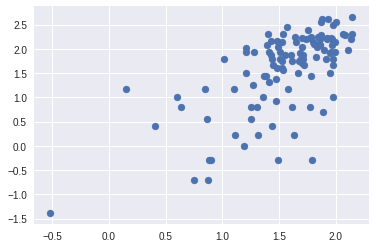

In [70]:
scatter(log(ps[:, 33]), log(bs[:, 33]))
# xlim(0, 20)
#ylim(0, 20)

1

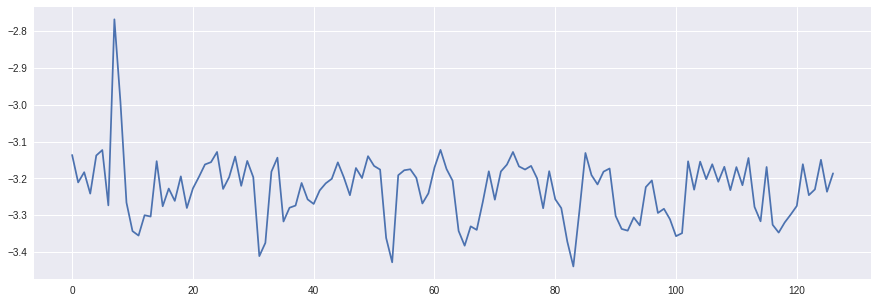

In [65]:
figure(figsize=(15,5))
mp = log((ps+ 10)).mean(axis=1, keepdims=True)+ log((ps+ 10)).mean(axis=0, keepdims=True)
len(plot((log(ps + 10) - mp)[:, 128]))

1

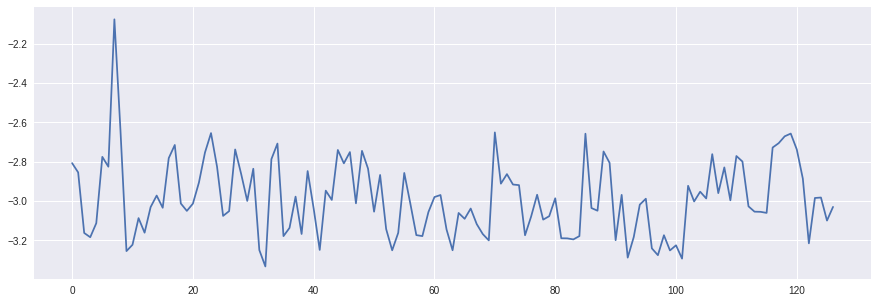

In [66]:
figure(figsize=(15,5))
m = log((bs+ 10)).mean(axis=1, keepdims=True)+ log((bs+ 10)).mean(axis=0, keepdims=True)
len(plot((log(bs + 10) - m)[:, 128]))

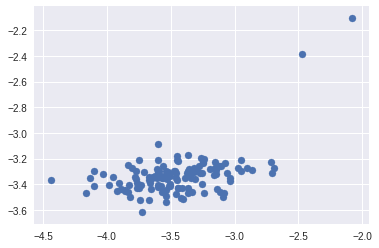

In [264]:
scatter((log(bs + 1) - m)[:, 318], (log(ps + 1) - mp)[:, 318])

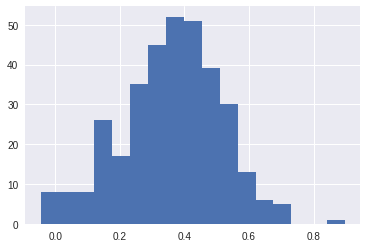

In [224]:
from scipy.stats import pearsonr, spearmanr

Rs = [pearsonr((ps - mp)[:, idx], (bs - m)[:, idx])[0] for idx in range(344)]
hist(Rs, 'auto');

In [227]:
(array(Rs) > .6).nonzero()

(array([  5,   7,   8,   9,  11,  14,  15,  97, 160, 161, 171, 230, 273,
        274, 317, 318, 326]),)

In [73]:
bamlist = [l.strip() for l in open("/mnt/DATA2/thouis/GM12878/bamlist.txt")]
d_to_g = {l.split('/')[0]: l.split('"')[1] for l in open("/mnt/DATA2/thouis/GM12878/file_to_gene.txt")}

In [82]:
g = [d_to_g[s.split('/')[1]] for s in bamlist]

['CEBPZ',
 'CEBPZ',
 'POLR2A',
 'POLR2A',
 'ZNF622',
 'ZNF622',
 'TBL1XR1',
 'TBL1XR1',
 'E2F8',
 'E2F8',
 'TRIM22',
 'TRIM22',
 'USF1',
 'USF1',
 'SIX5',
 'SIX5',
 'IKZF1',
 'IKZF1',
 'UBTF',
 'UBTF',
 'EED',
 'EED',
 'ASH2L',
 'ASH2L',
 'SKIL',
 'SKIL',
 'NBN',
 'NBN',
 'RELA',
 'RELA',
 'RELA',
 'RELA',
 'IRF3',
 'IRF3',
 'E4F1',
 'E4F1',
 'MXI1',
 'MXI1',
 'POLR2A',
 'POLR2A',
 'TBP',
 'TBP',
 'ELK1',
 'ELK1',
 'RUNX3',
 'RUNX3',
 'NR2C2',
 'NR2C2',
 'SMAD1',
 'SMAD1',
 'BCLAF1',
 'BCLAF1',
 'TRIM22',
 'TRIM22',
 'PBX3',
 'PBX3',
 'RAD51',
 'RAD51',
 'RB1',
 'RB1',
 'RXRA',
 'RXRA',
 'MYC',
 'MYC',
 'IRF5',
 'IRF5',
 'CTCF',
 'CTCF',
 'MAX',
 'MAX',
 'PAX8',
 'PAX8',
 'IKZF1',
 'IKZF1',
 'STAT3',
 'STAT3',
 'MLLT1',
 'MLLT1',
 'ZNF207',
 'ZNF207',
 'SRF',
 'SRF',
 'REST',
 'REST',
 'HSF1',
 'HSF1',
 'RELB',
 'RELB',
 'BMI1',
 'BMI1',
 'NRF1',
 'NRF1',
 'SMAD5',
 'SMAD5',
 'CTCF',
 'CTCF',
 'NFE2',
 'NFE2',
 'ZNF384',
 'ZNF384',
 'CEBPB',
 'CEBPB',
 'BATF',
 'BATF',
 'PAX5',
 'PAX5'

In [83]:
genelist = list(set(g))
g_to_i = [genelist.index(gn) for gn in g]


In [93]:
def merge(vals):
    out = np.zeros((vals.shape[0], len(genelist)))
    for i, gi in enumerate(g_to_i):
        out[:, gi] += vals[:, i]
    return out

1

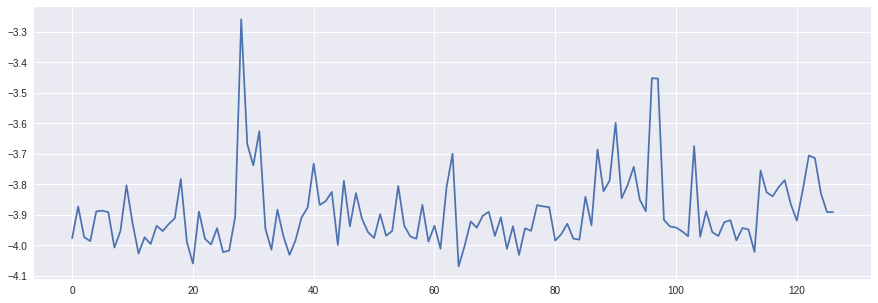

In [135]:
figure(figsize=(15,5))
psm = merge(ps)
mp = log((psm+ 10)).mean(axis=1, keepdims=True)+ log((psm+ 10)).mean(axis=0, keepdims=True)
len(plot((log(psm + 10) - mp)[:, 134]))

1

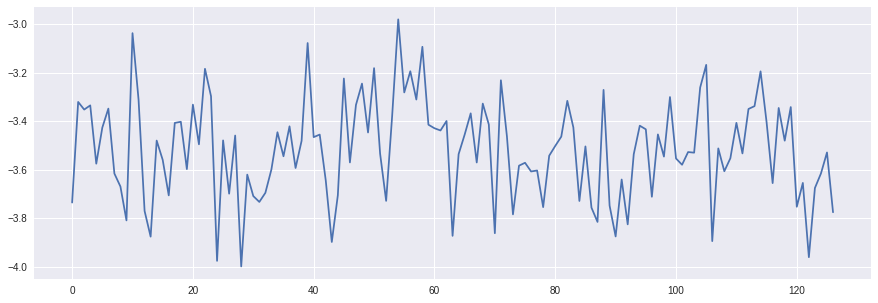

In [136]:
figure(figsize=(15,5))
bsm = merge(bs)
m = log((bsm+ 10)).mean(axis=1, keepdims=True)+ log((bsm+ 10)).mean(axis=0, keepdims=True)
len(plot((log(bsm + 10) - m)[:, 134]))

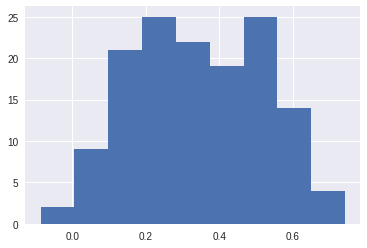

In [137]:
from scipy.stats import pearsonr, spearmanr

Rs = [pearsonr((psm - mp)[:, idx], (bsm - m)[:, idx])[0] for idx in range(141)]
hist(Rs, 'auto');

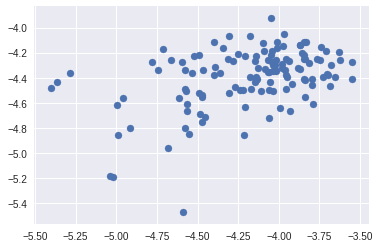

In [138]:
scatter((log(bsm + 1) - m)[:, 13], (log(psm + 1) - mp)[:, 13])

/home/thouis/VENV/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


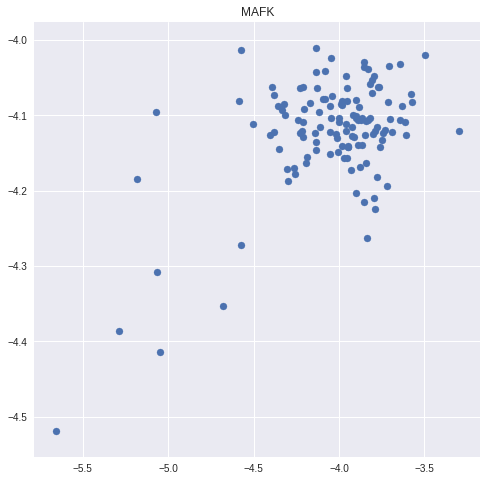

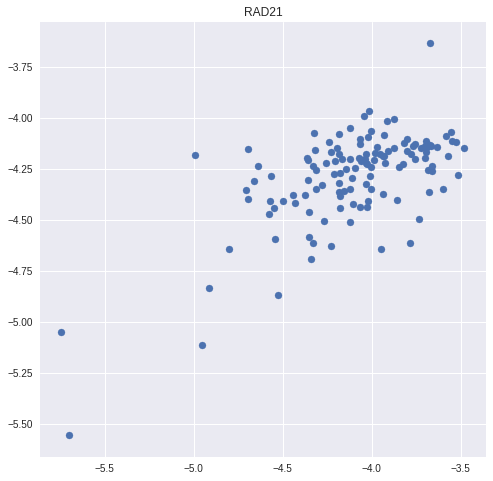

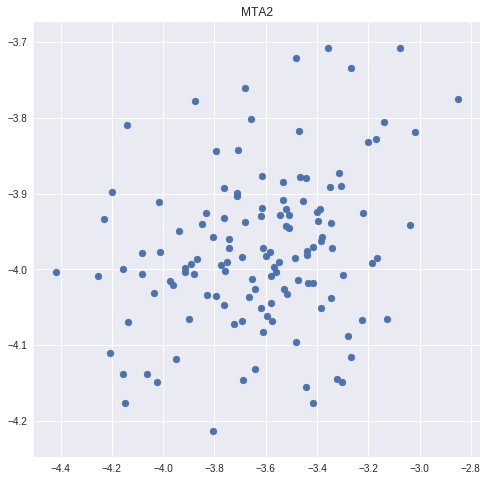

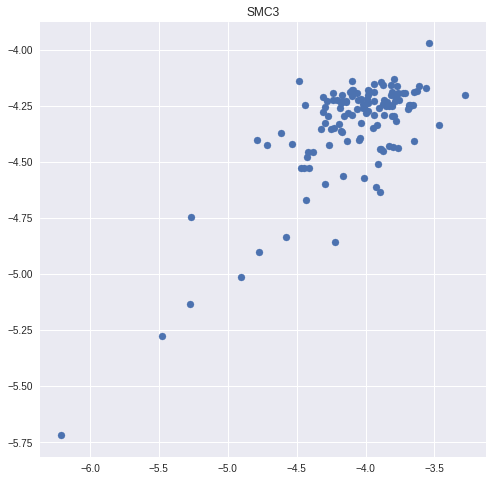

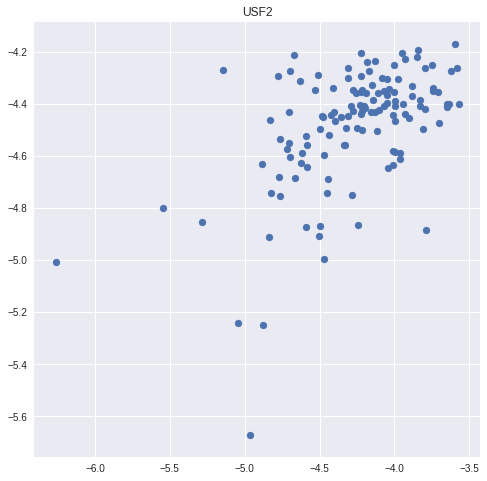

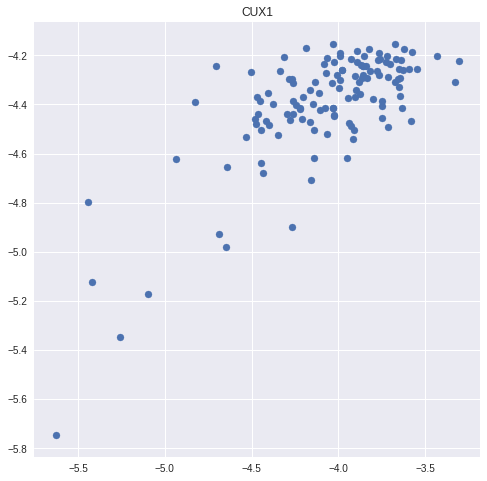

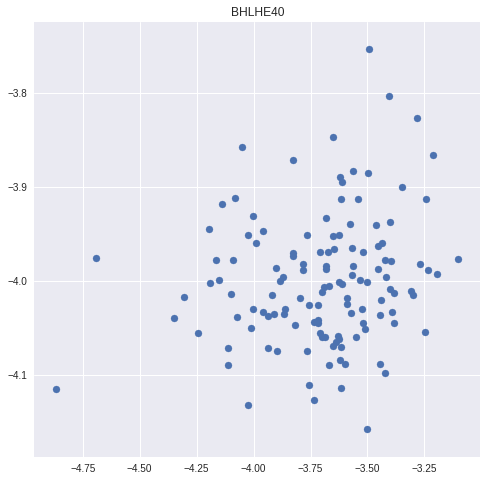

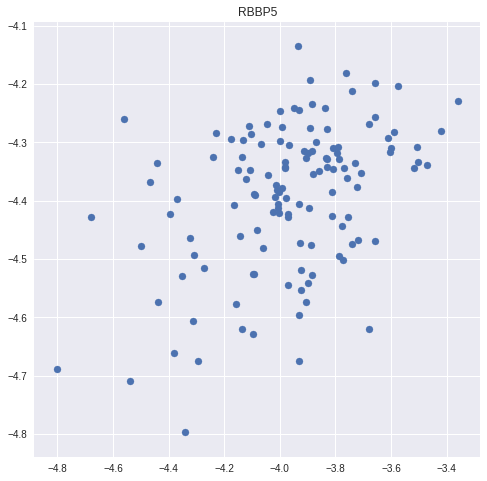

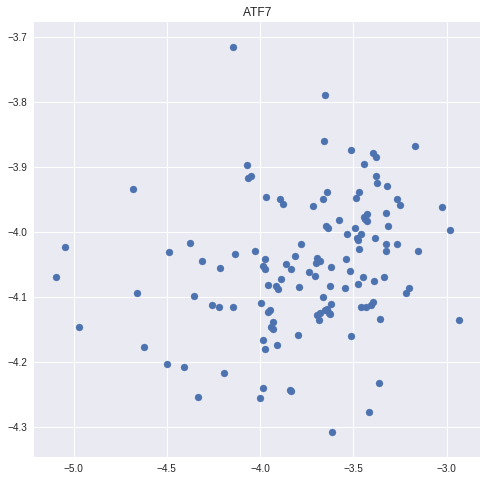

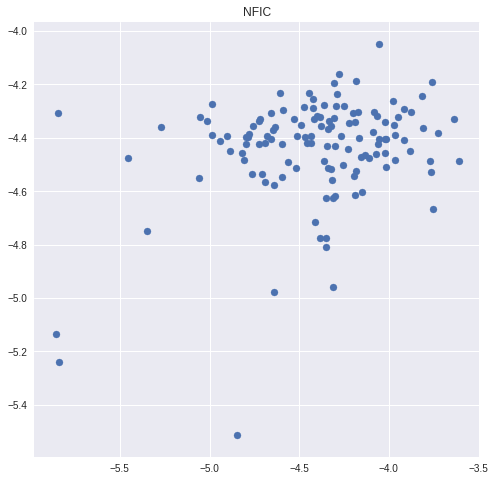

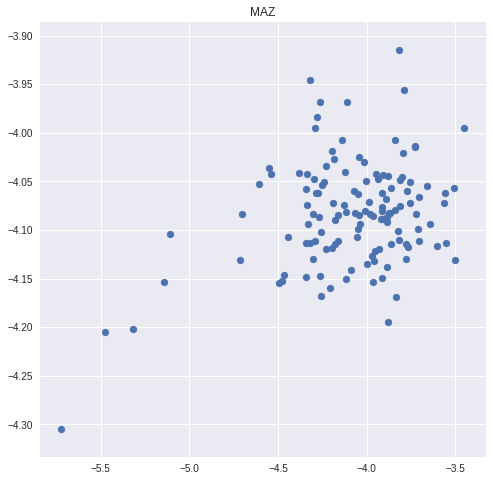

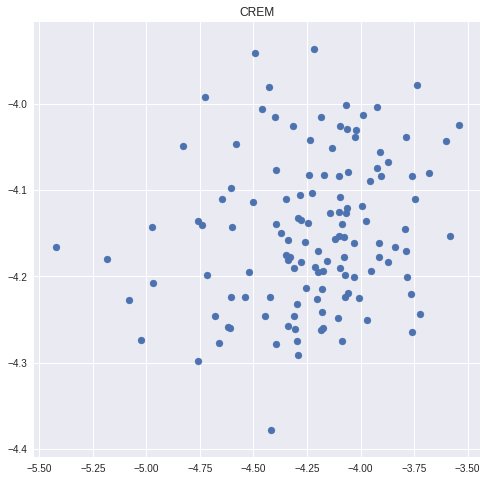

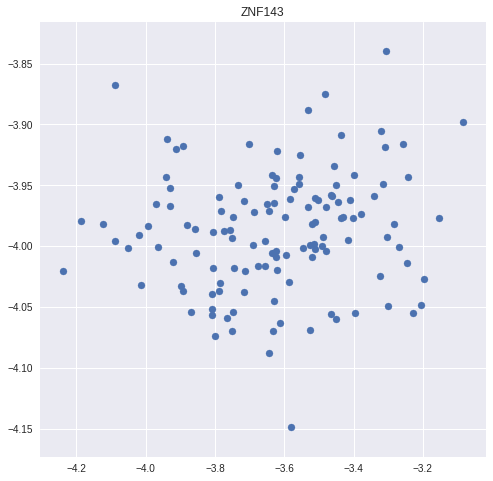

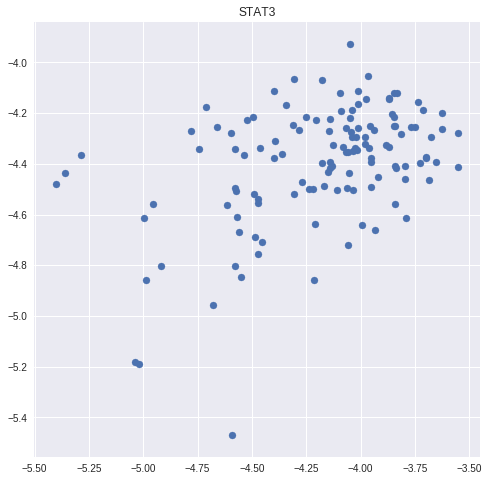

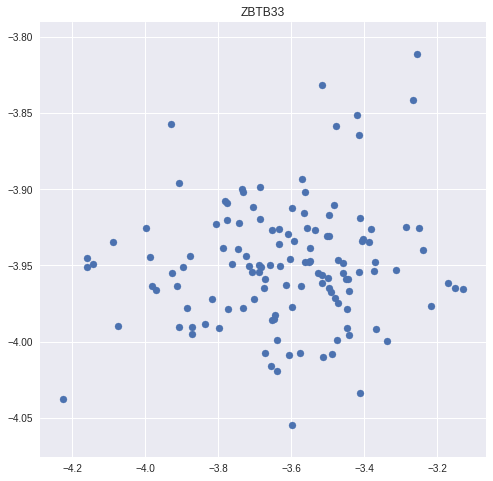

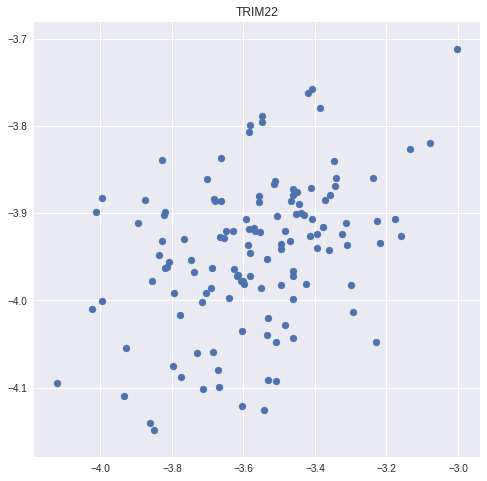

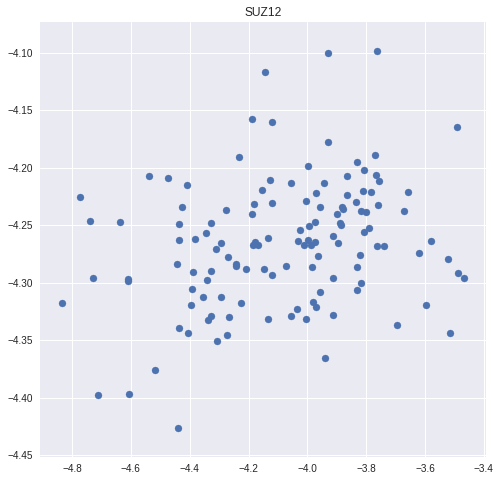

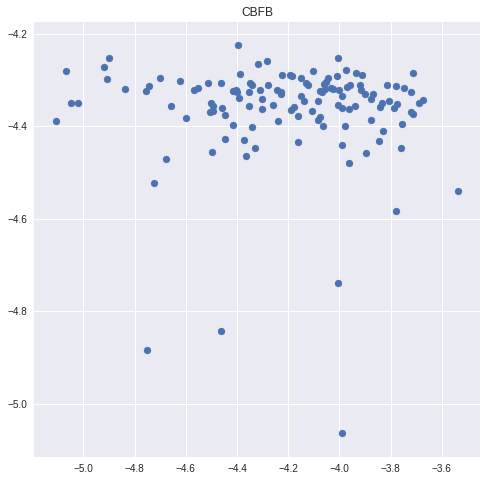

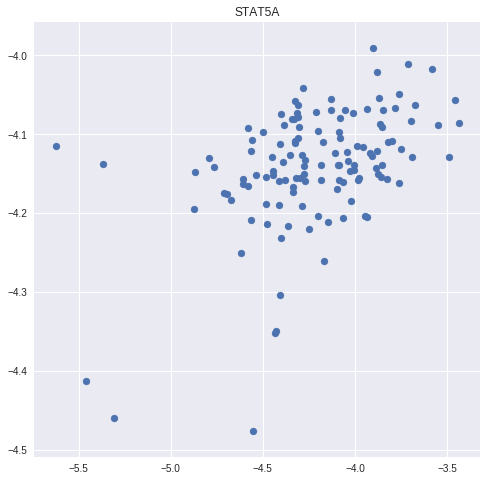

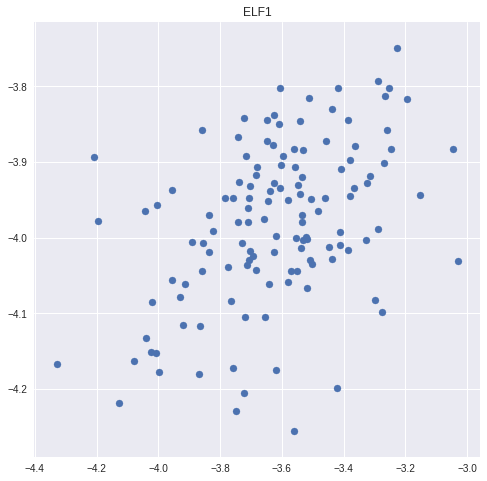

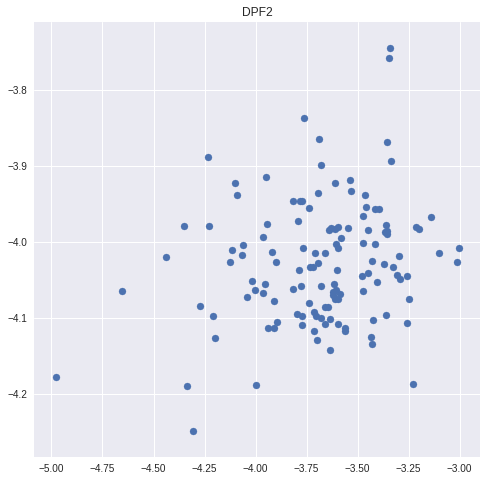

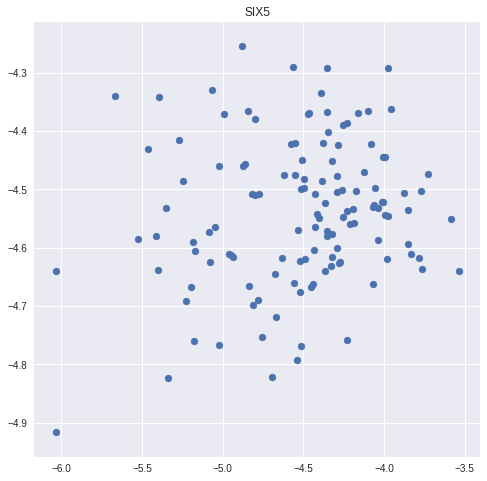

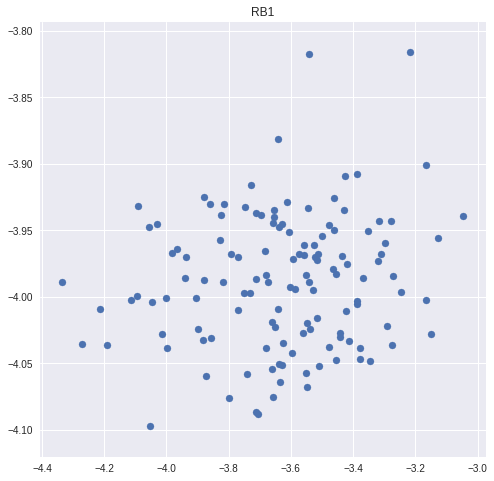

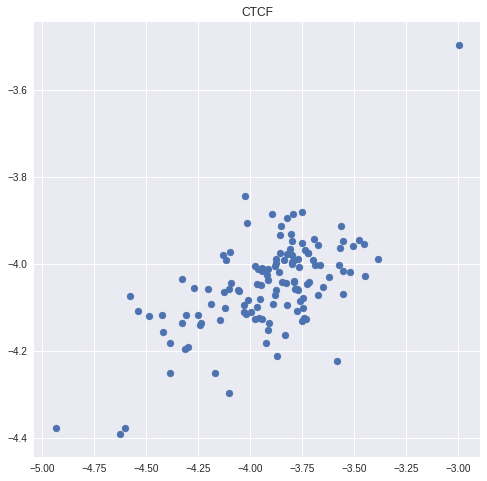

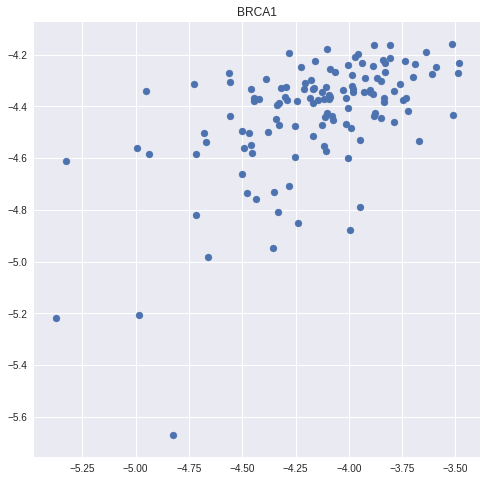

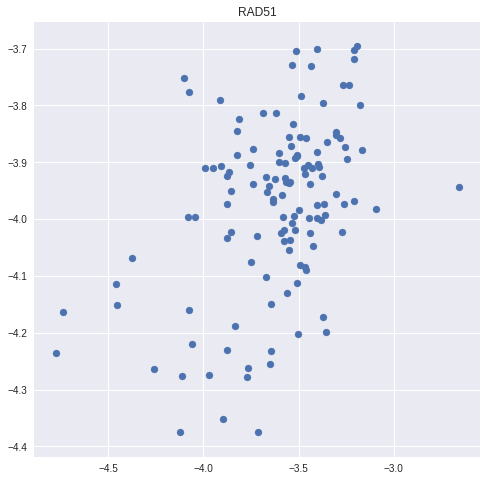

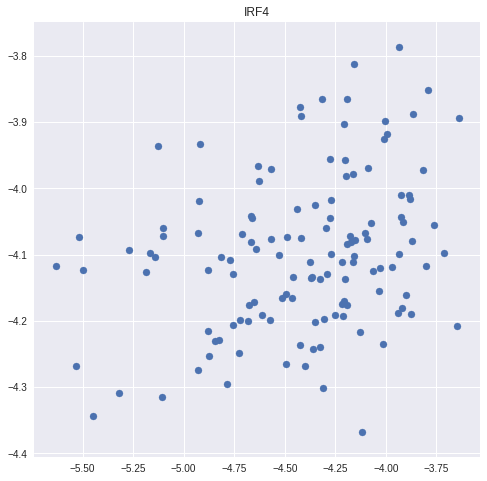

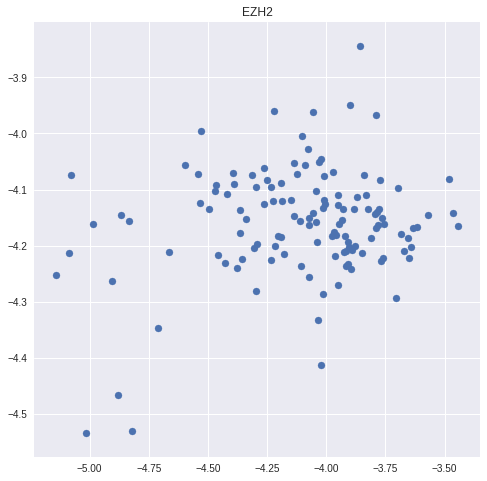

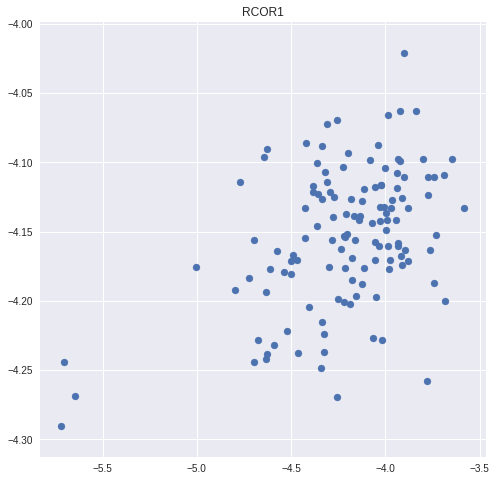

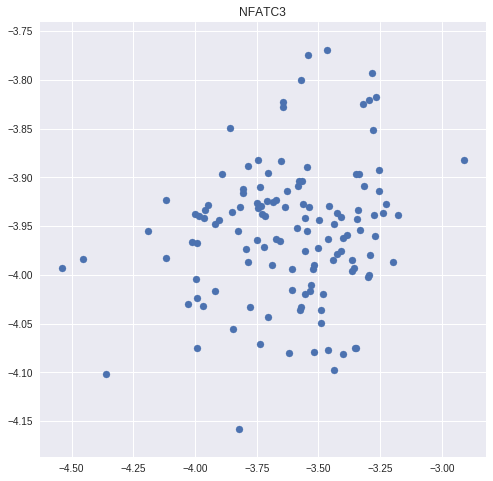

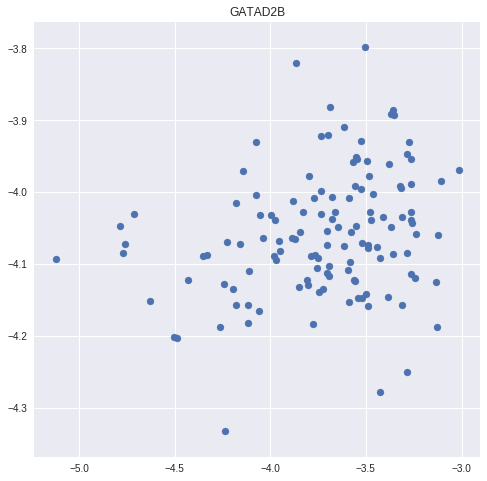

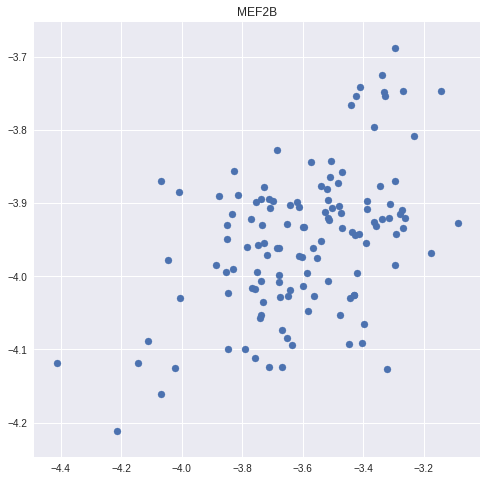

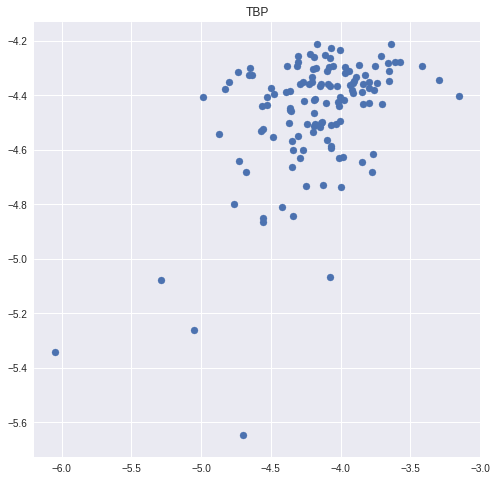

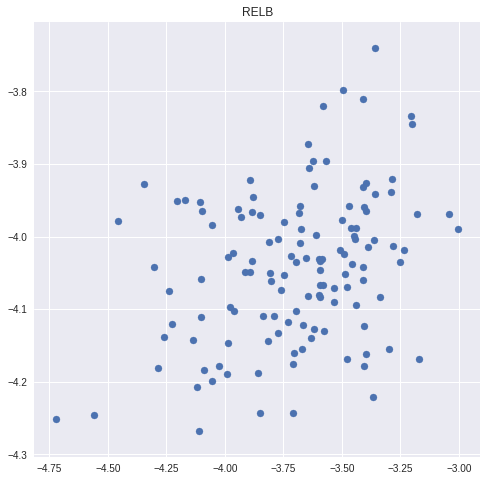

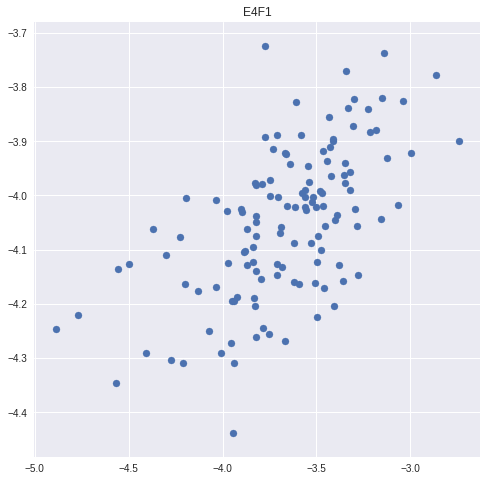

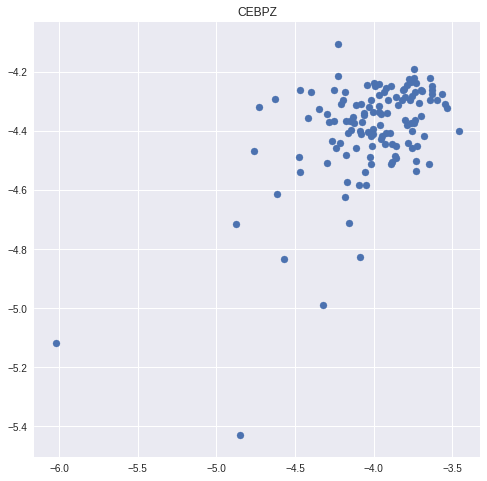

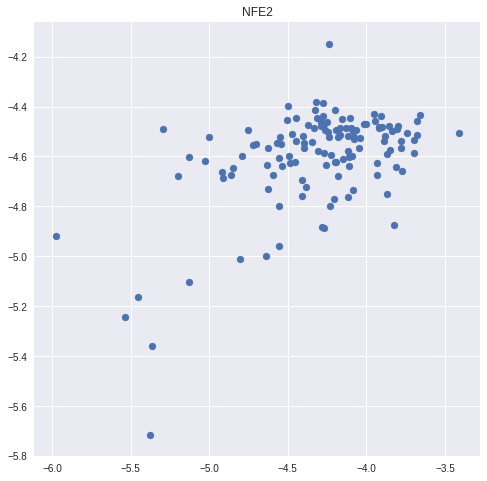

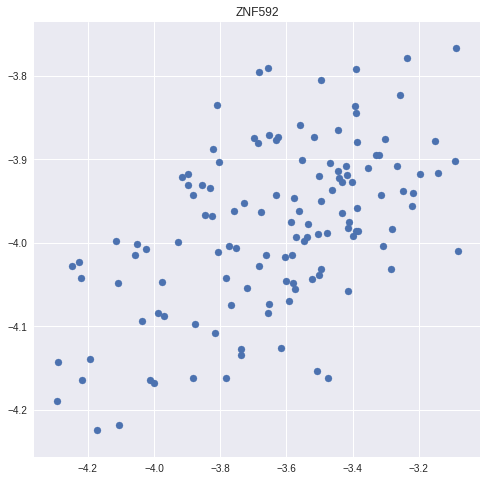

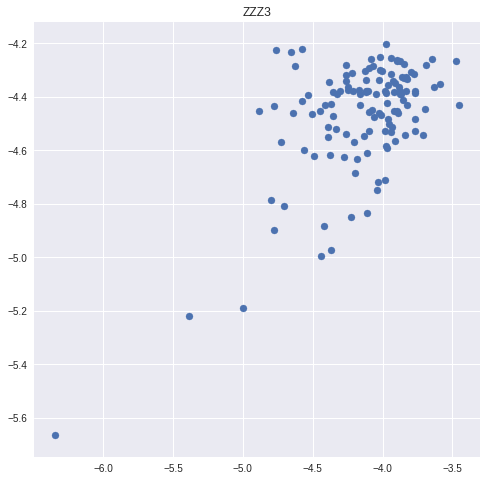

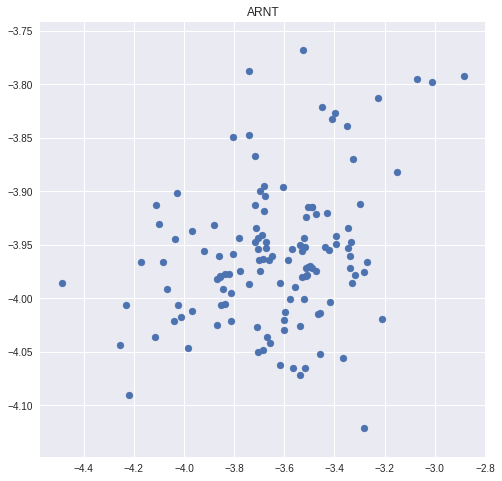

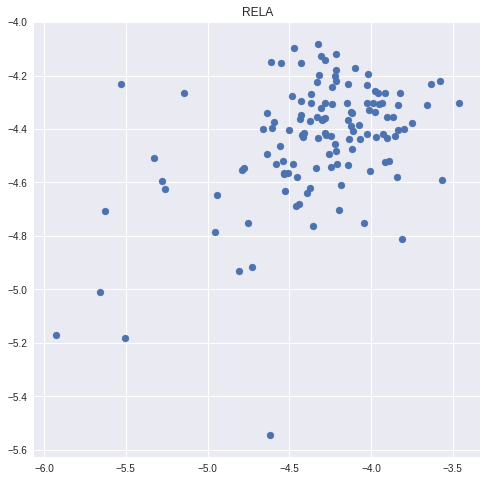

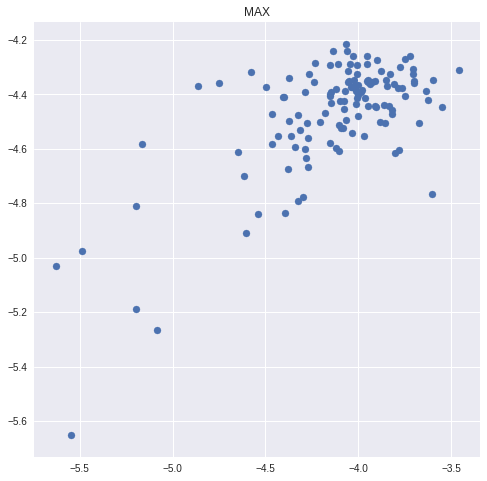

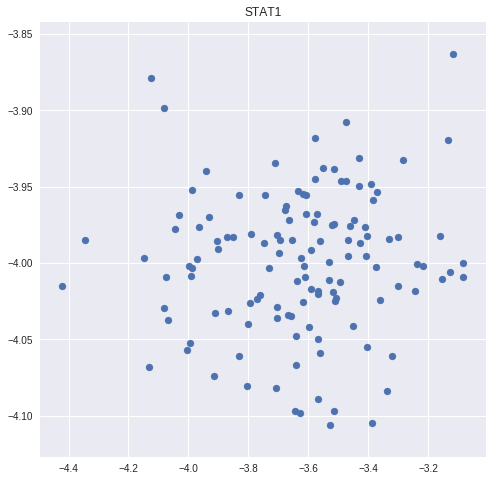

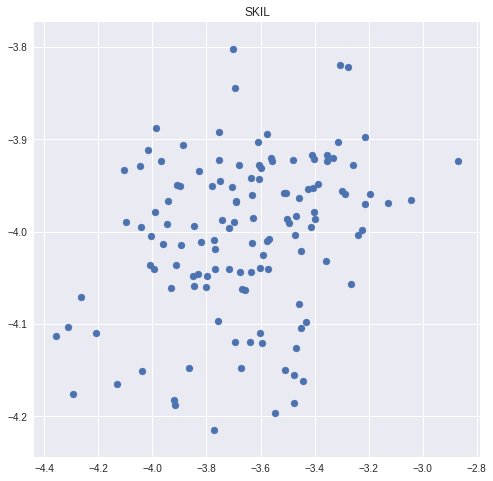

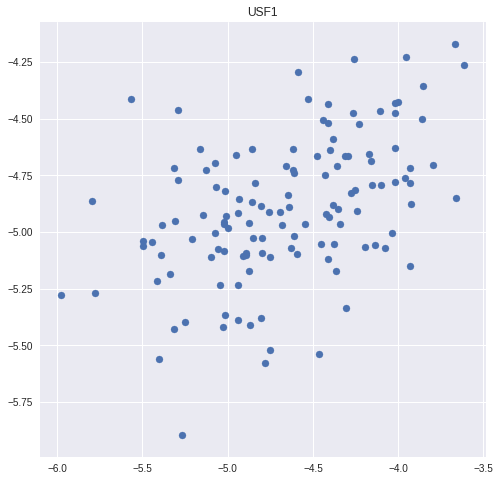

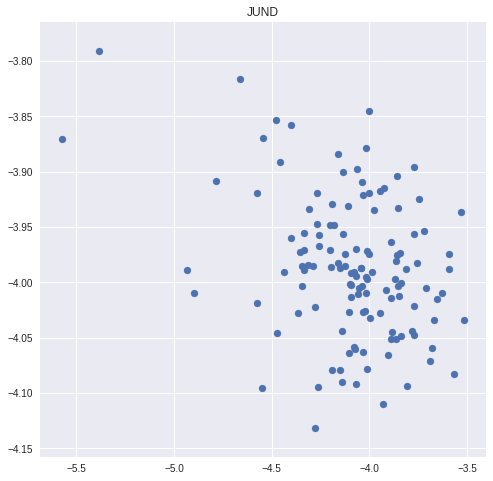

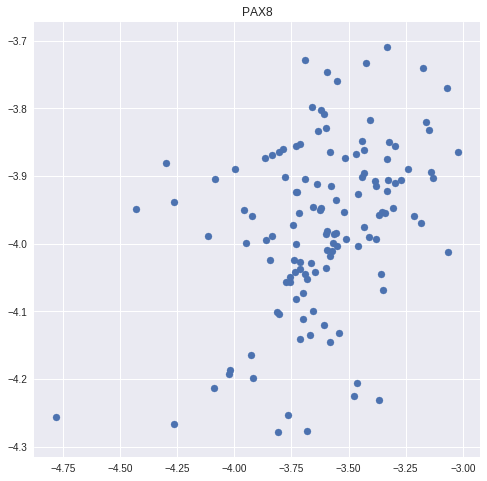

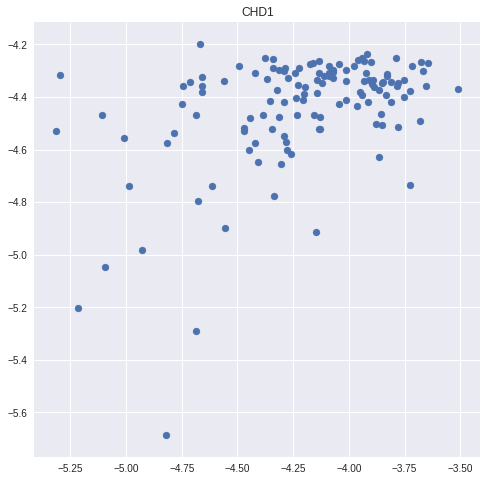

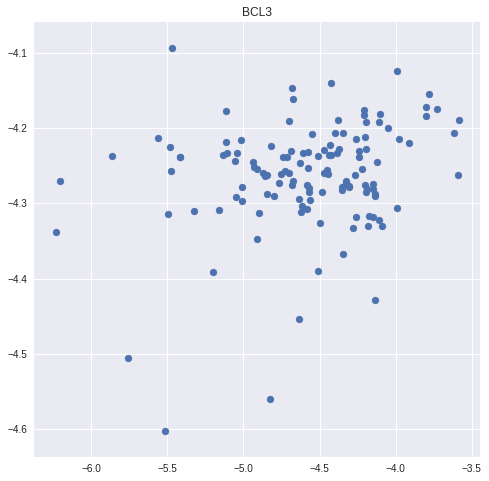

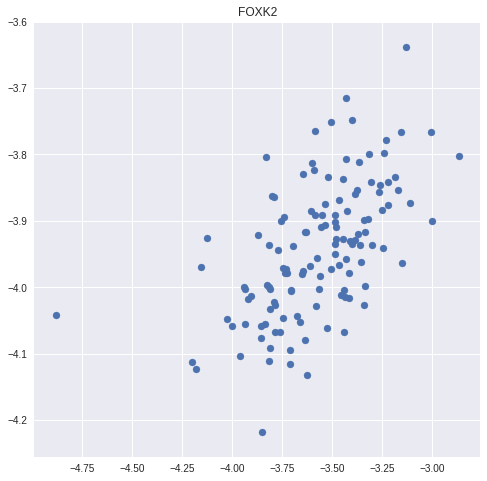

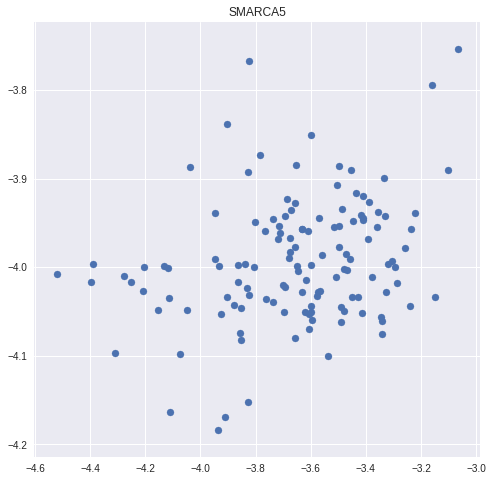

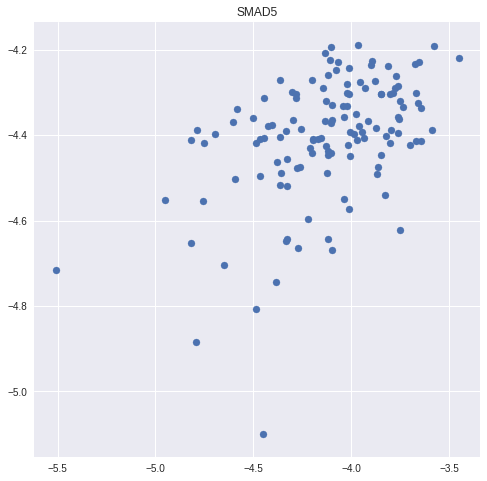

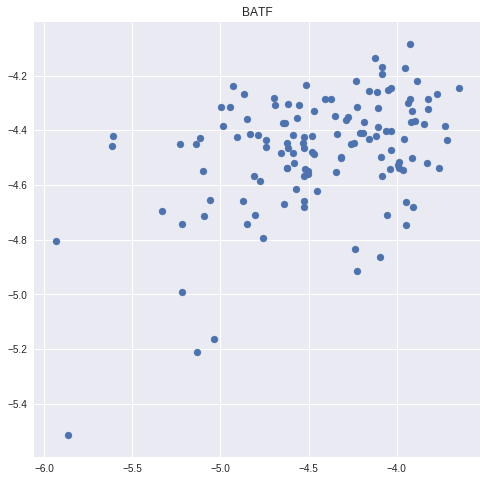

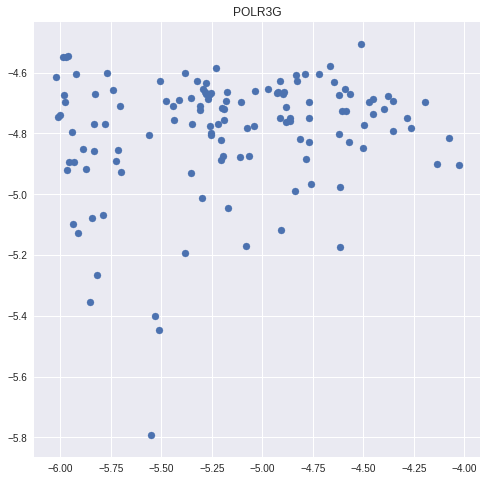

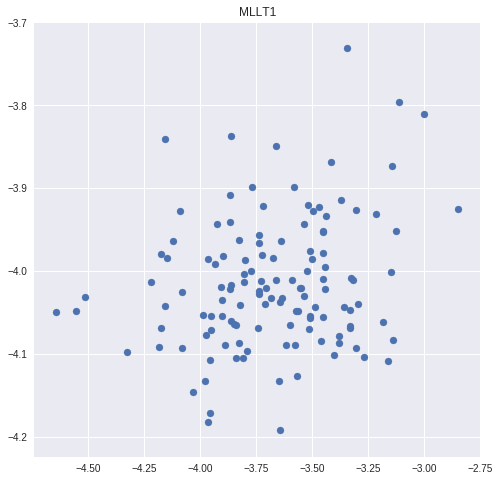

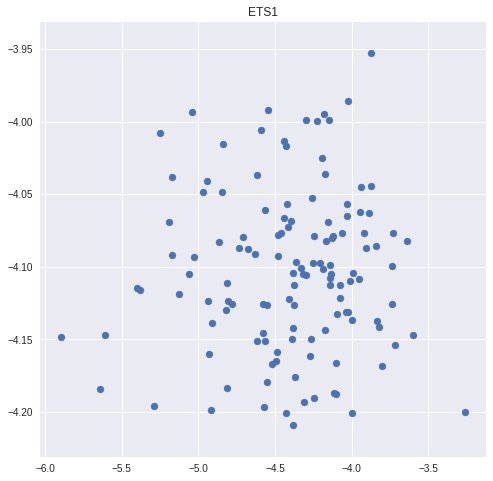

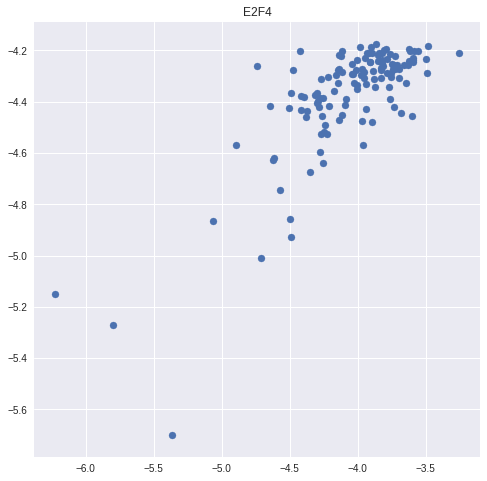

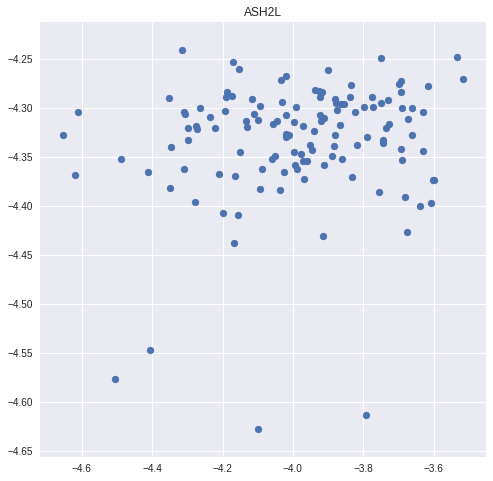

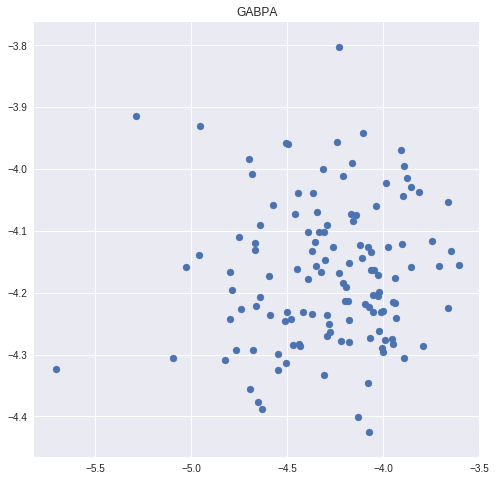

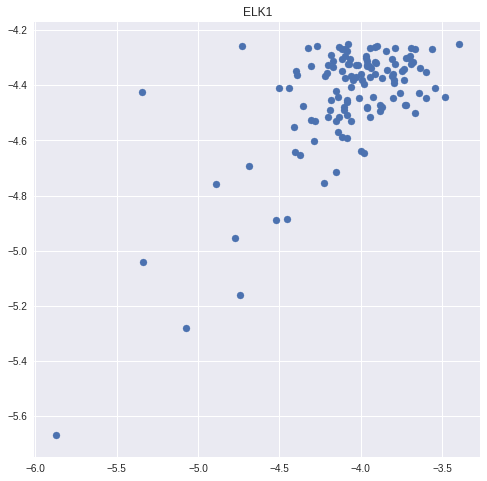

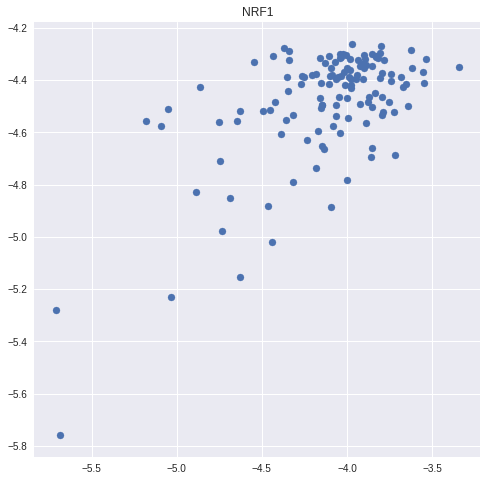

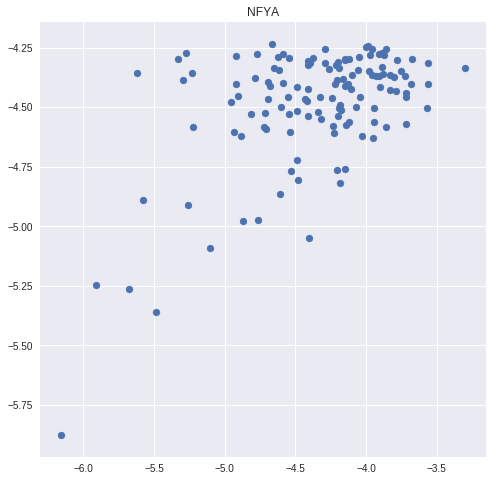

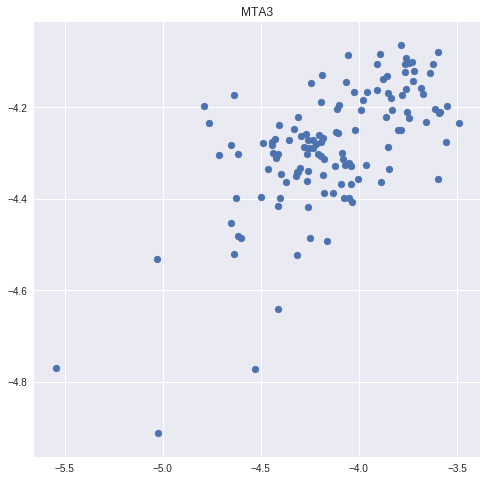

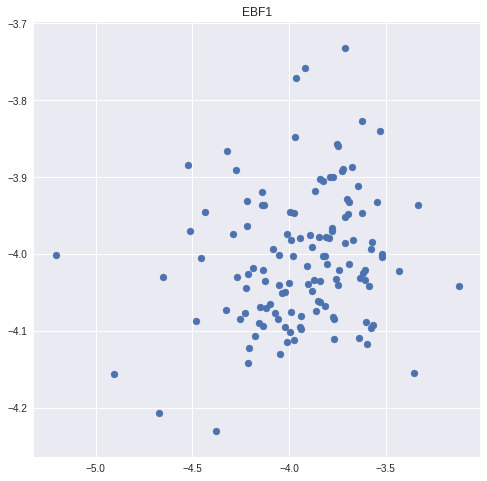

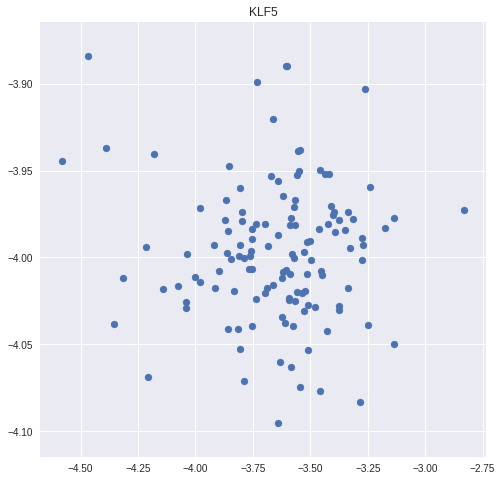

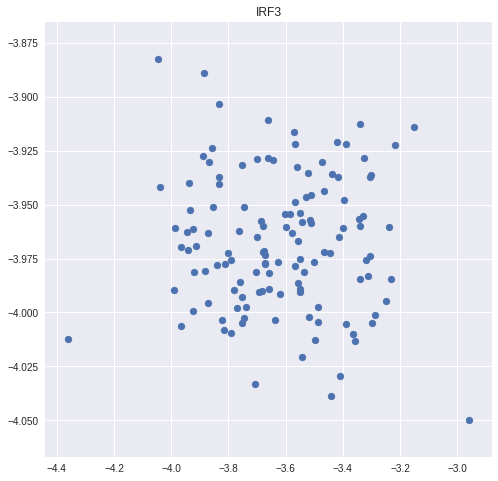

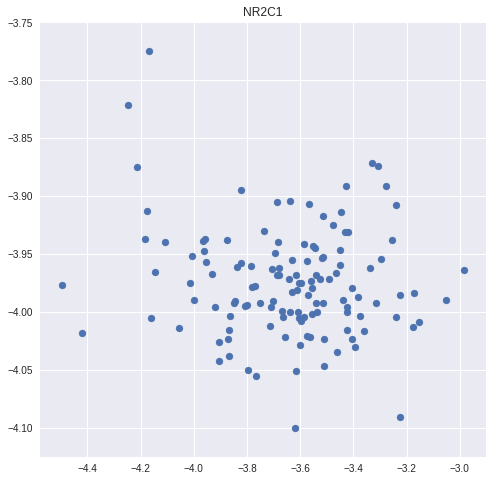

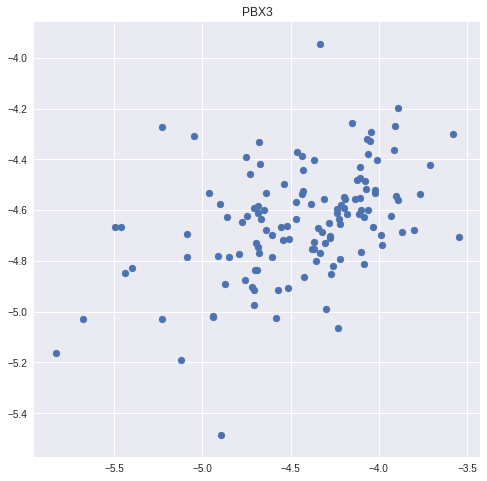

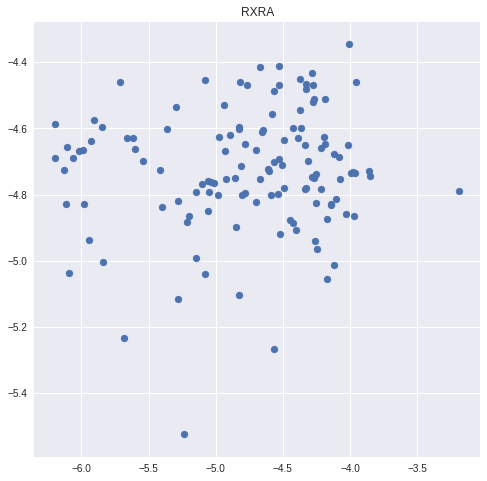

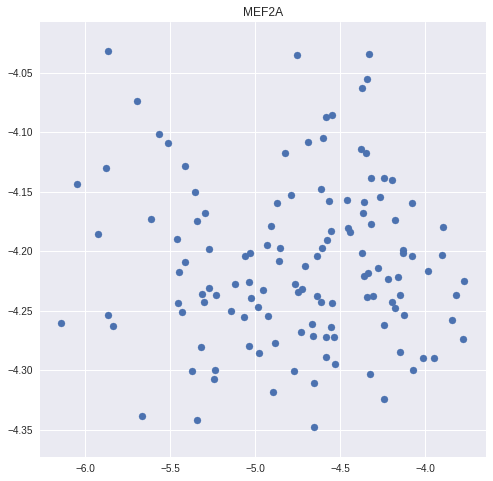

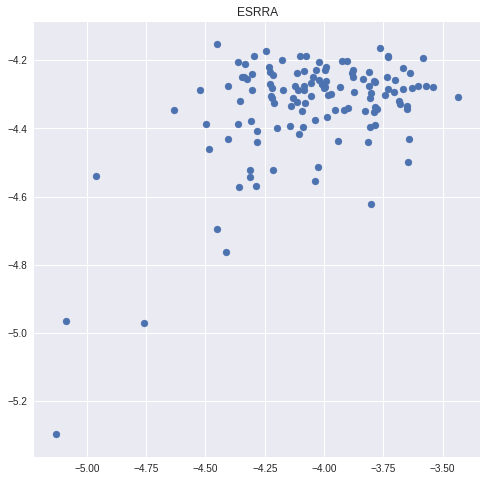

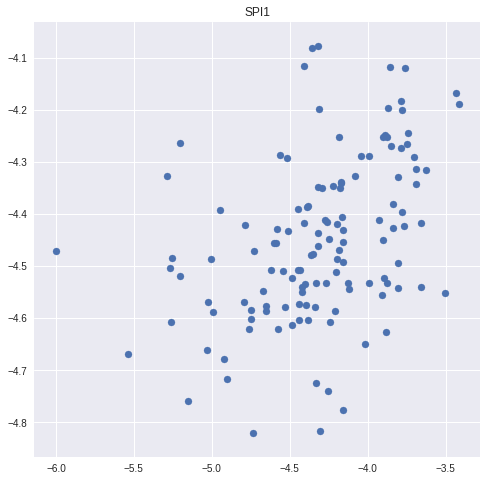

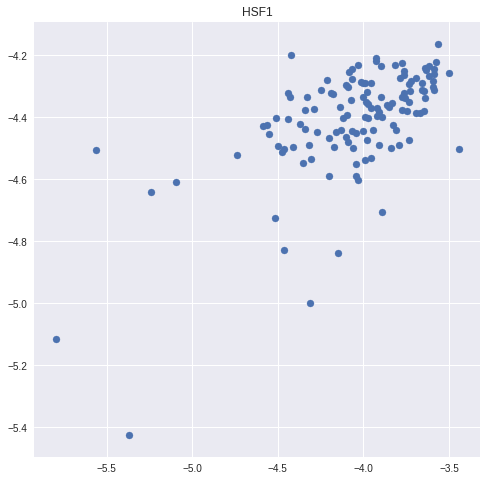

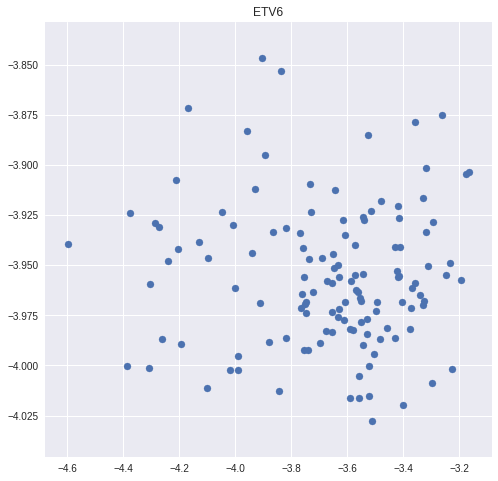

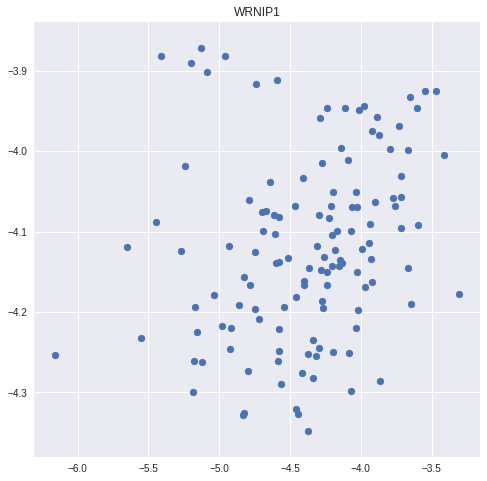

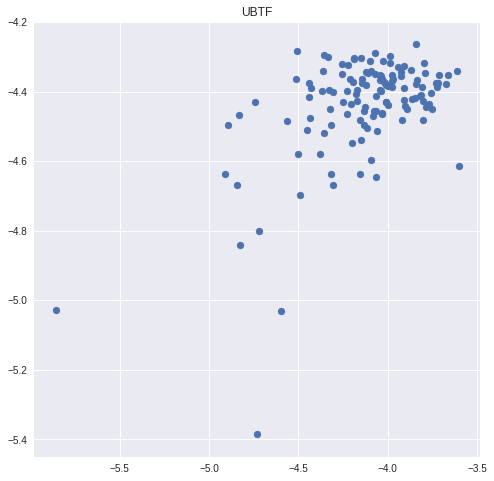

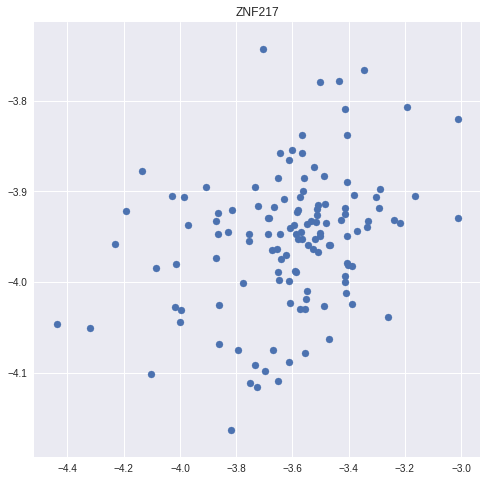

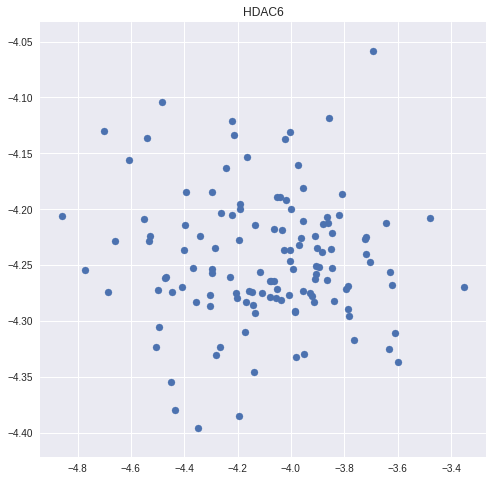

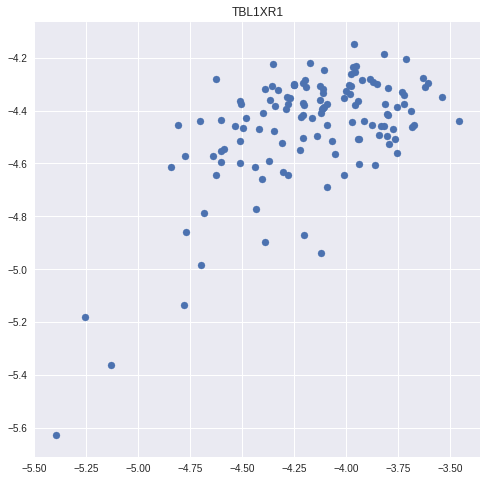

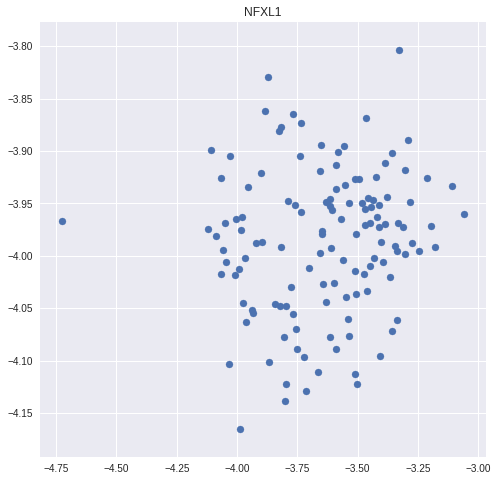

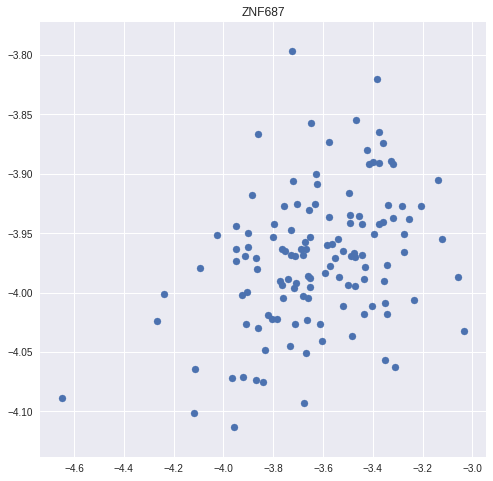

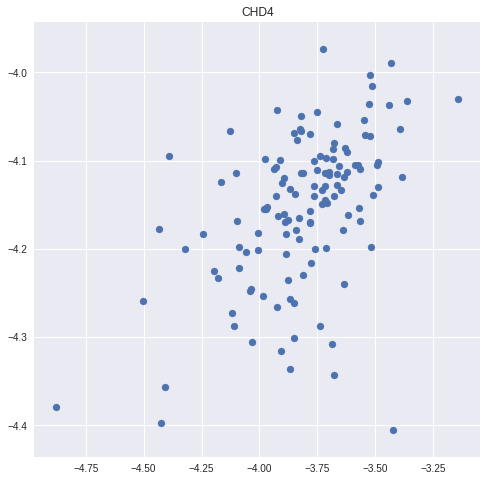

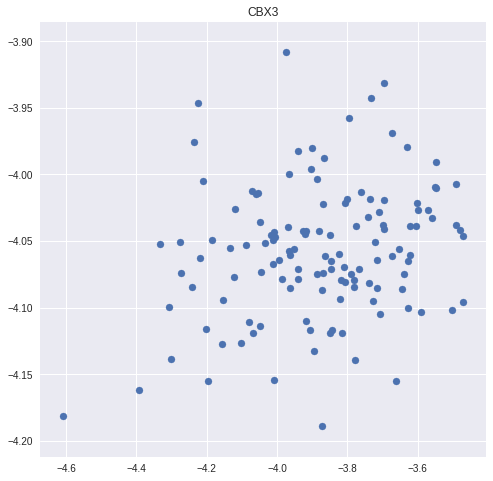

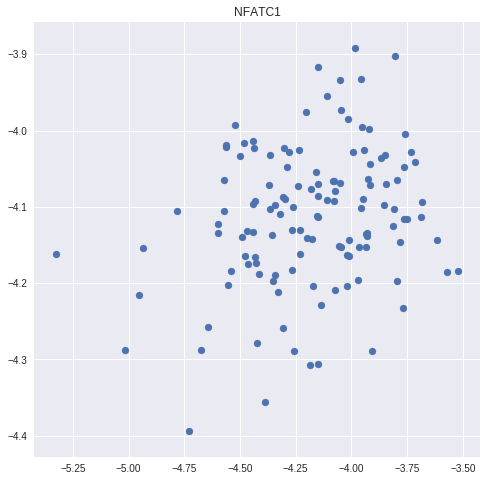

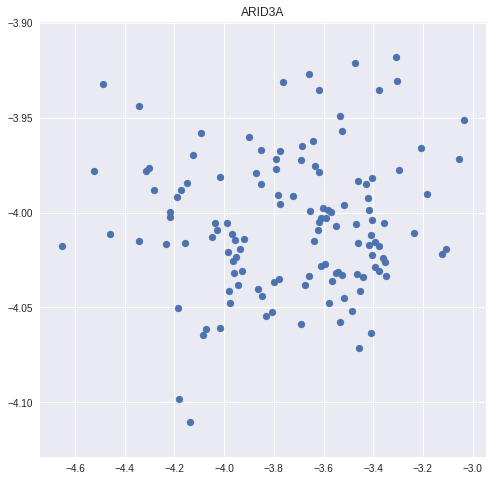

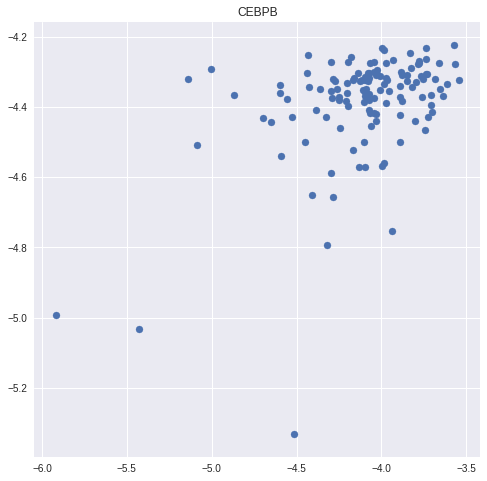

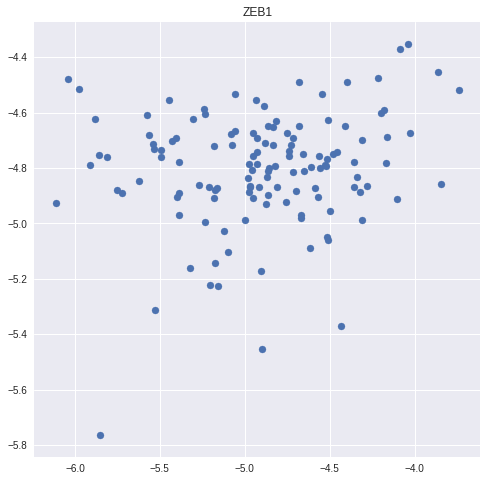

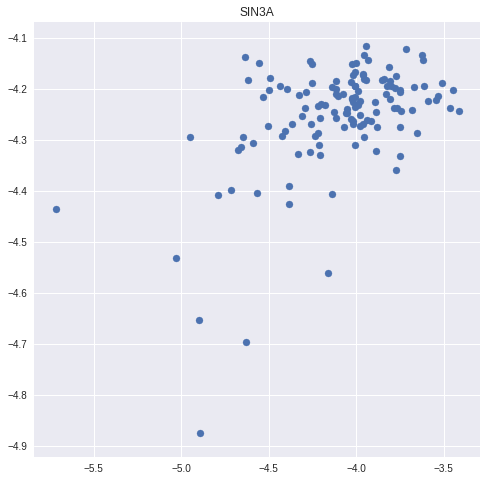

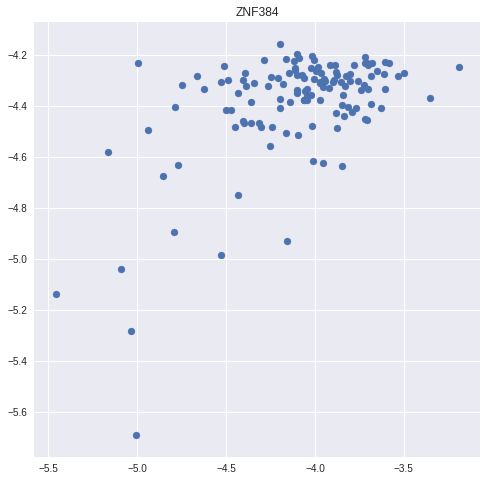

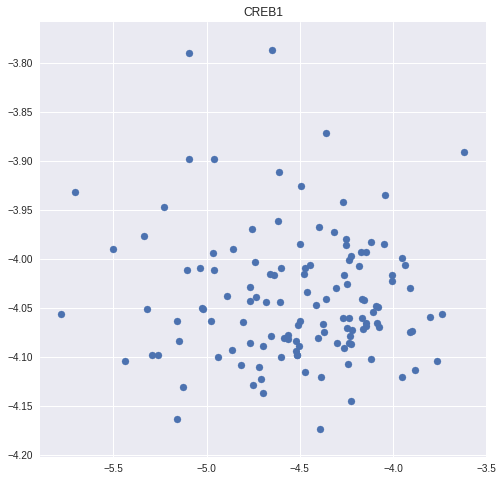

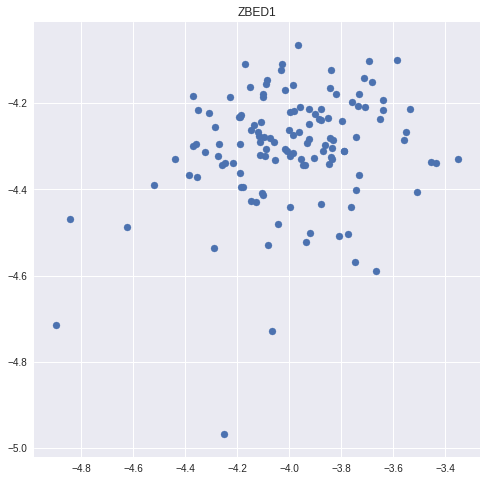

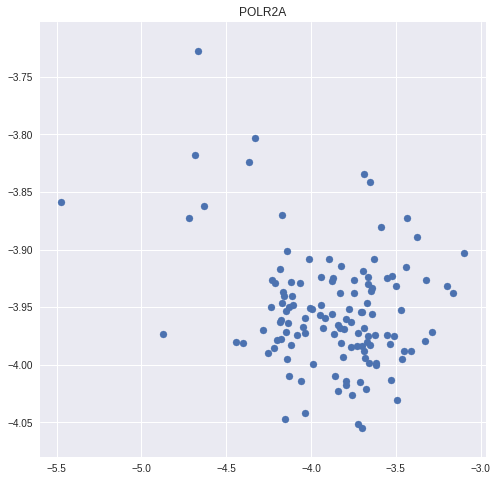

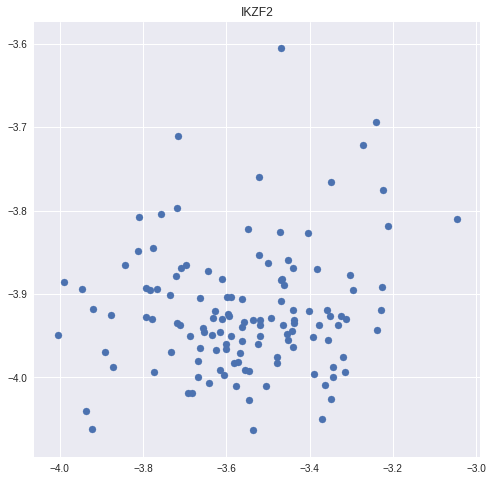

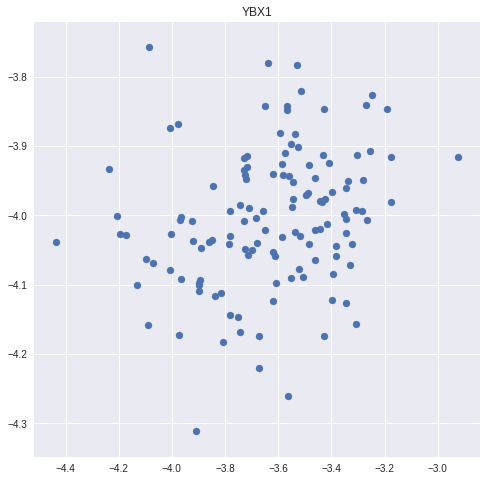

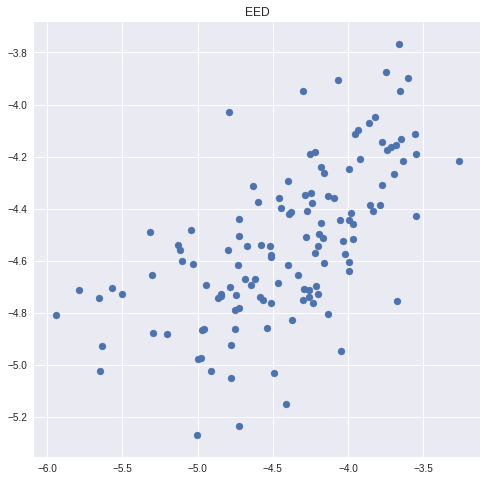

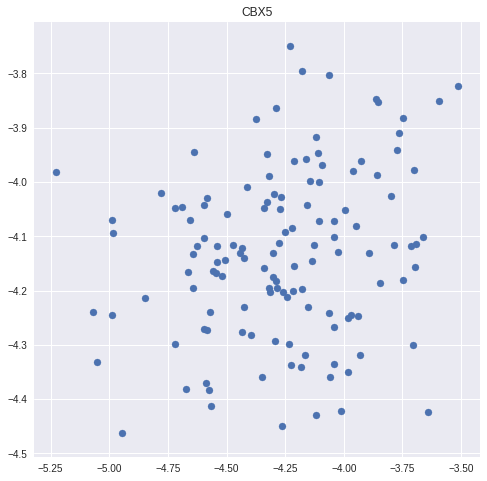

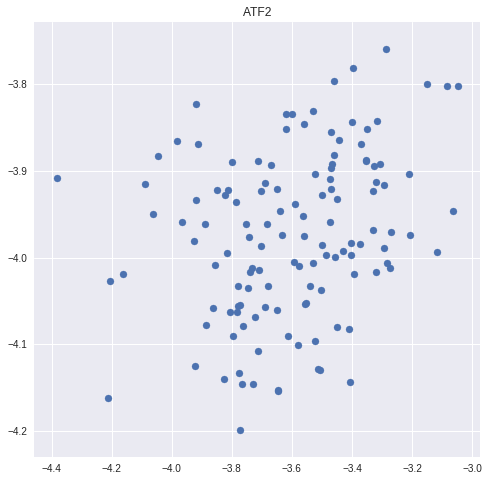

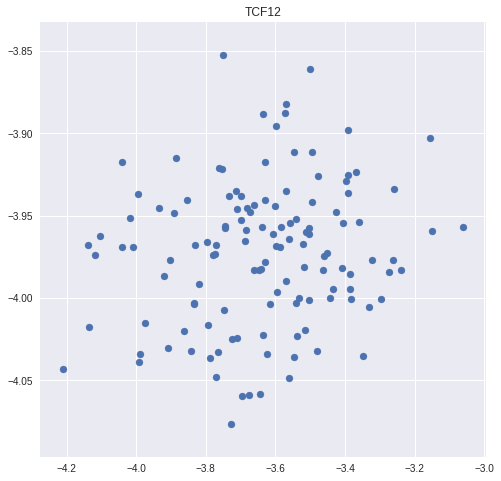

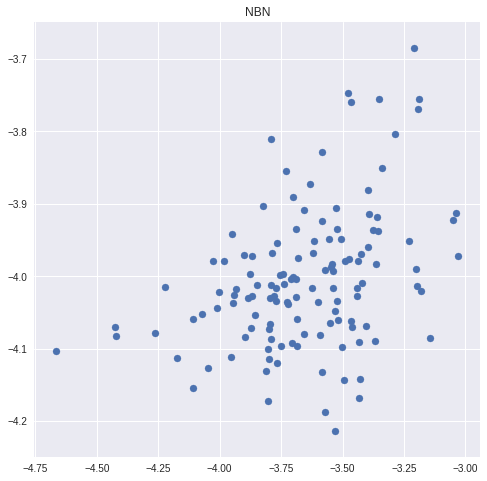

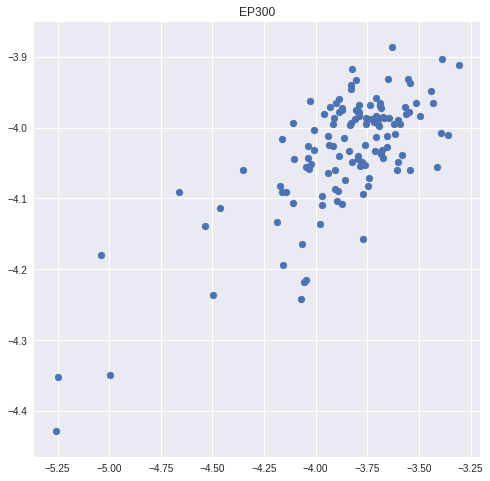

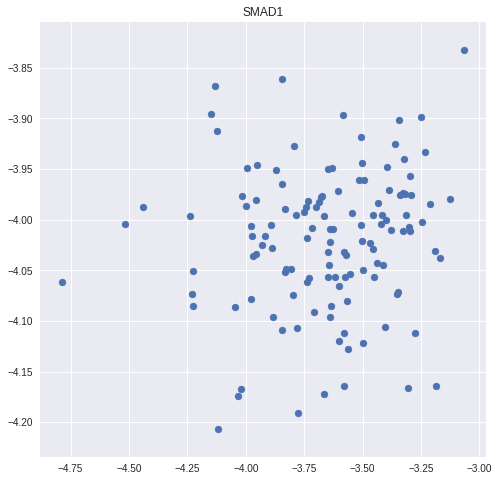

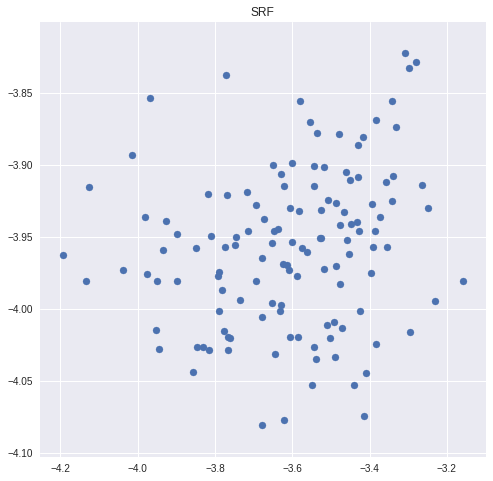

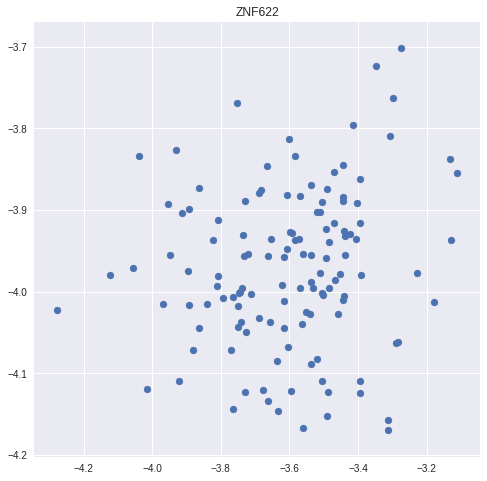

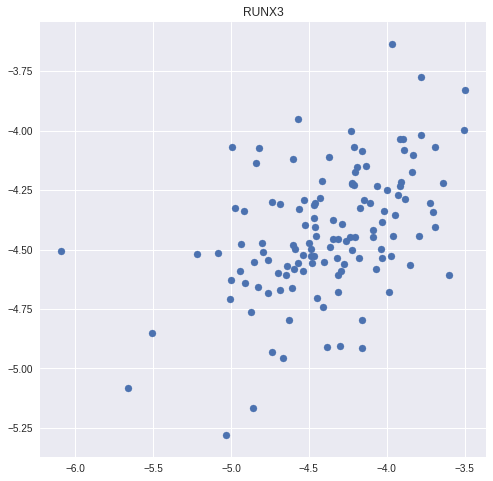

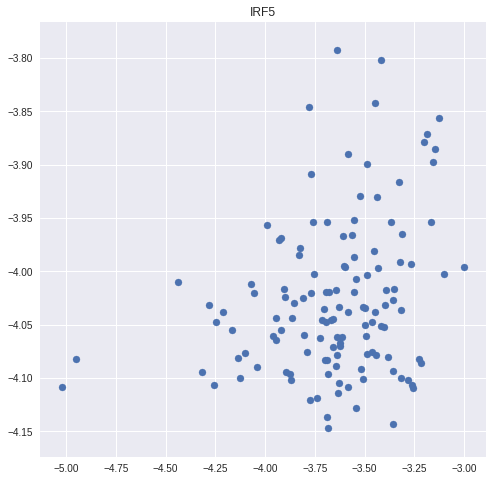

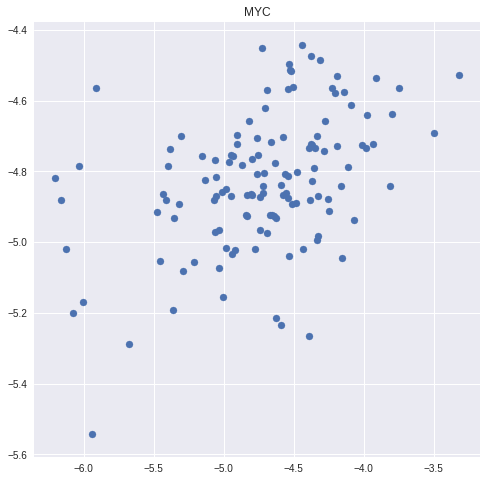

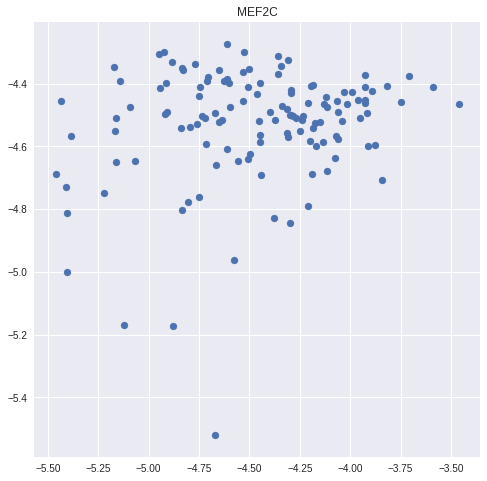

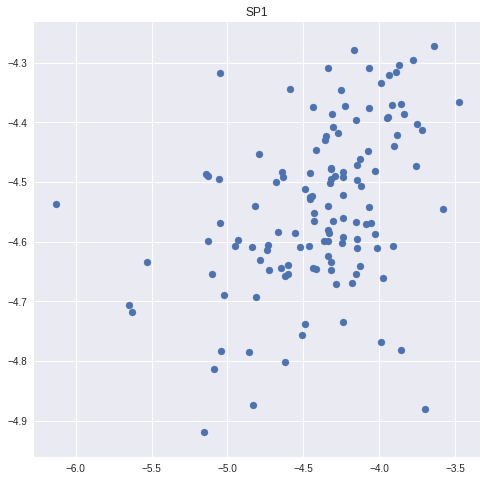

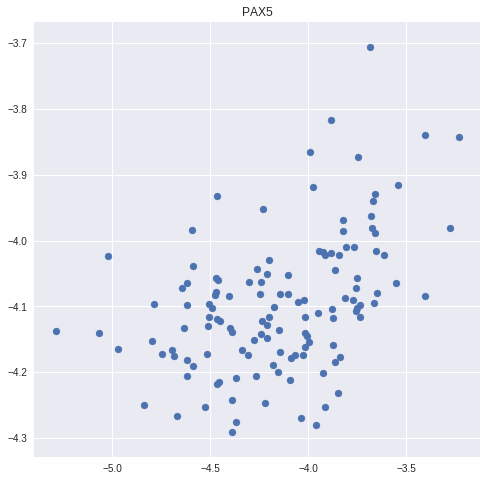

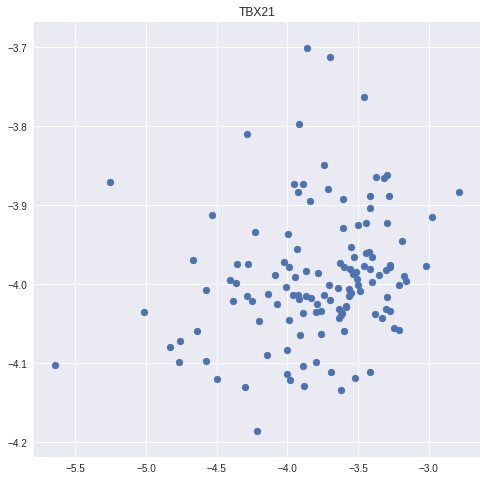

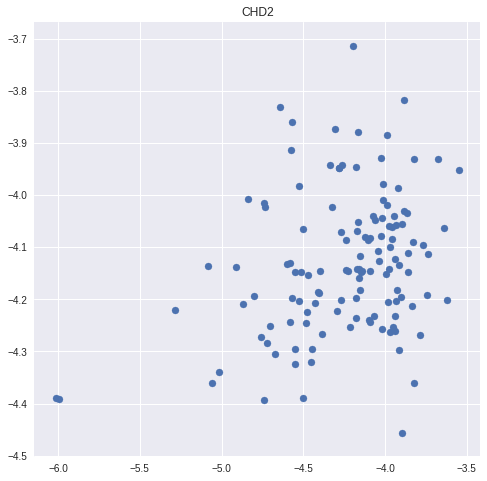

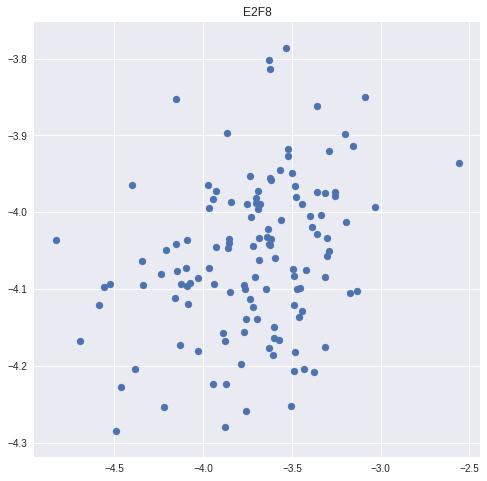

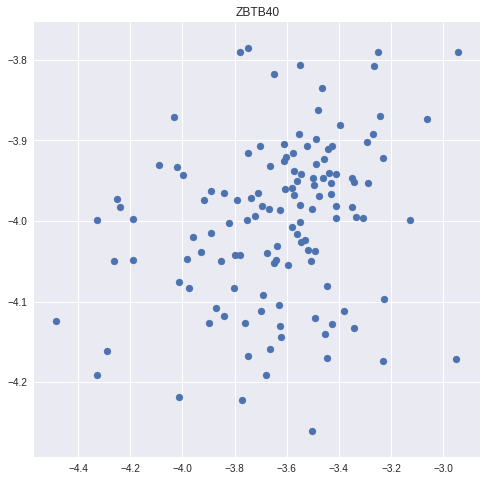

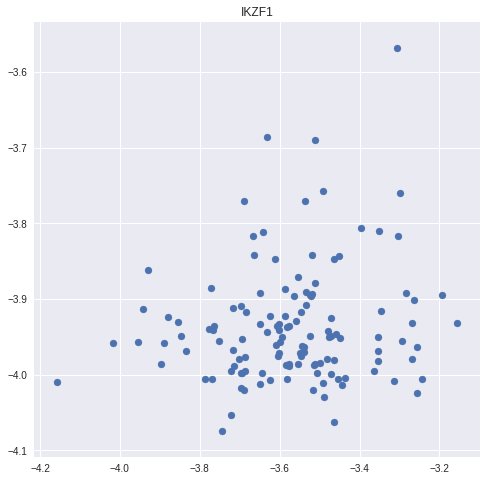

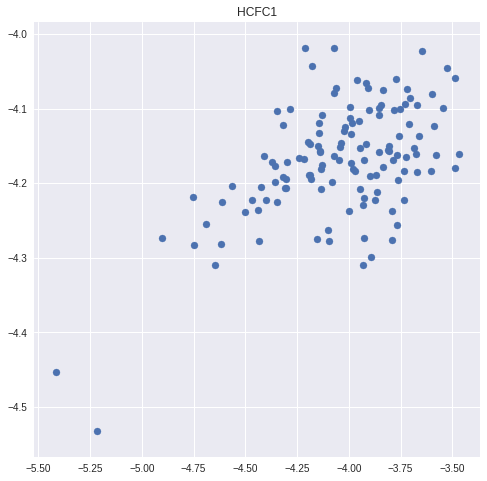

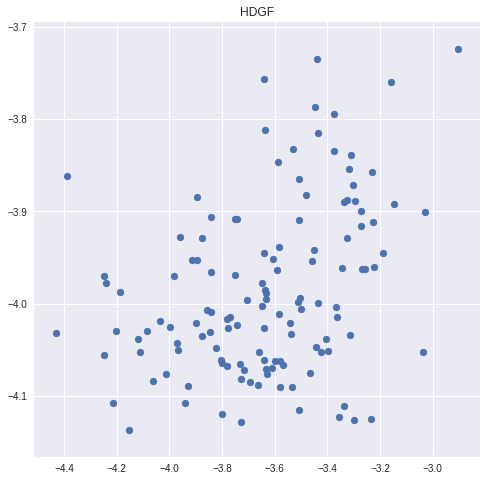

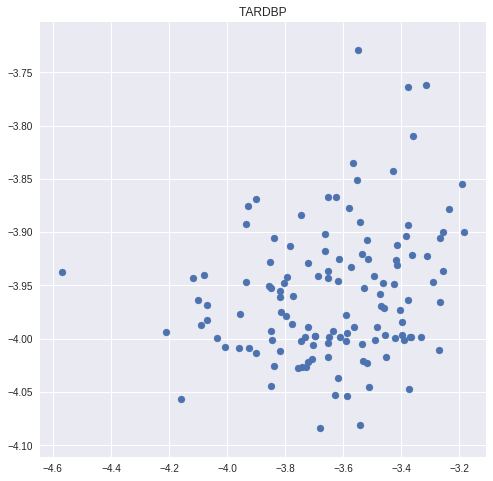

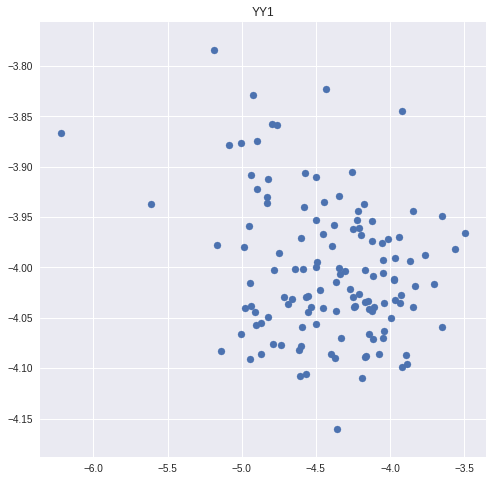

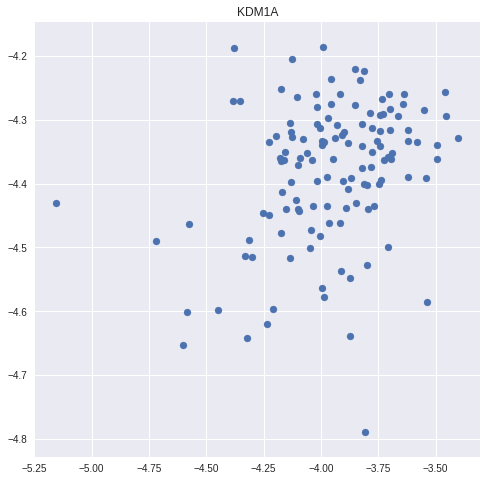

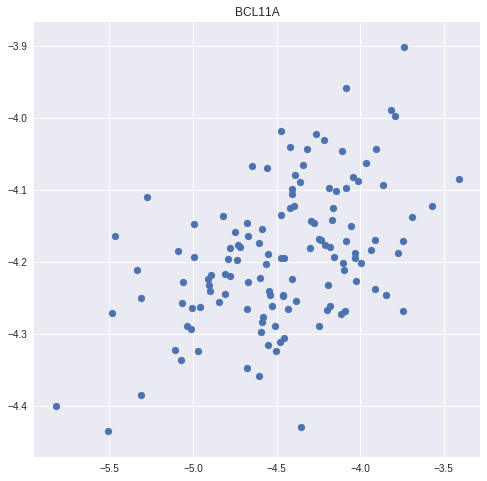

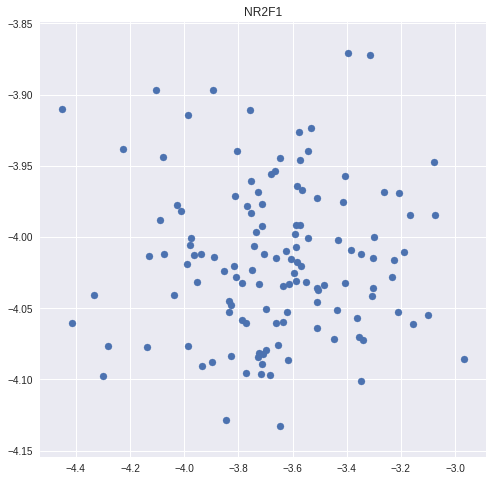

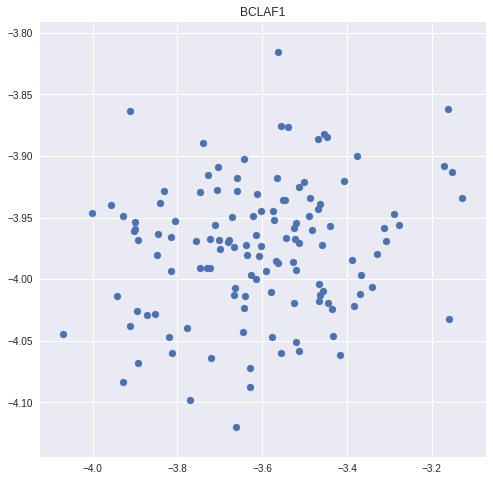

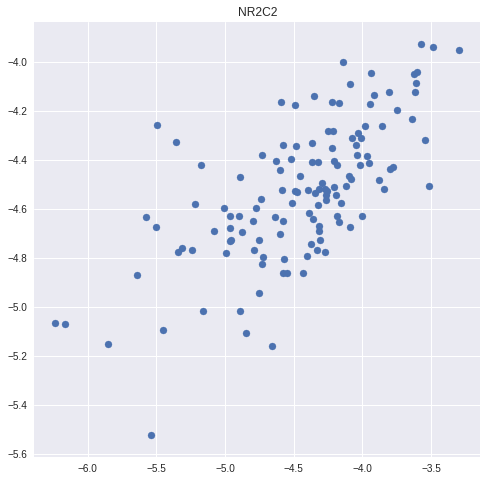

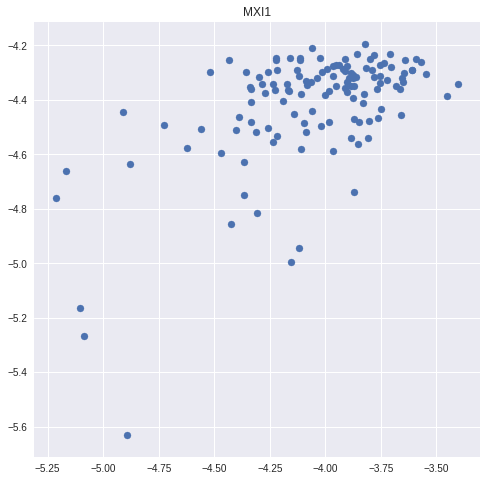

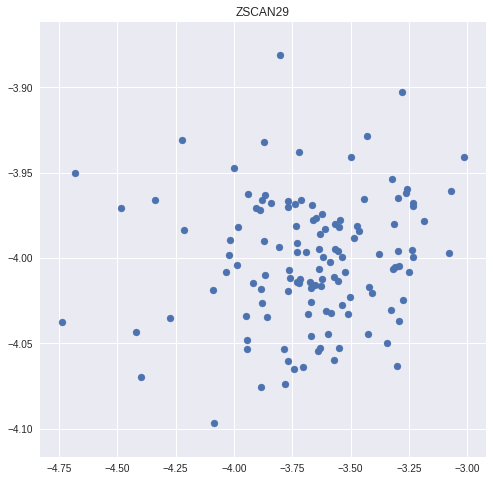

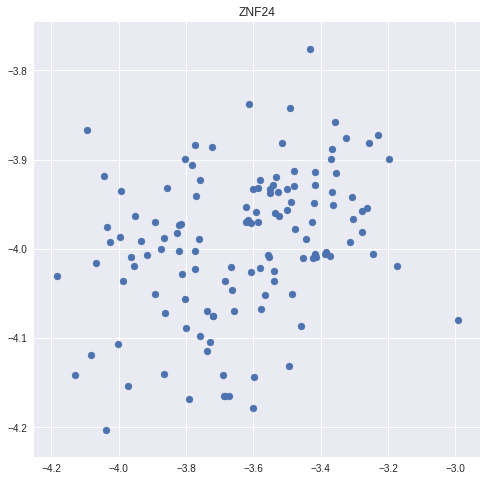

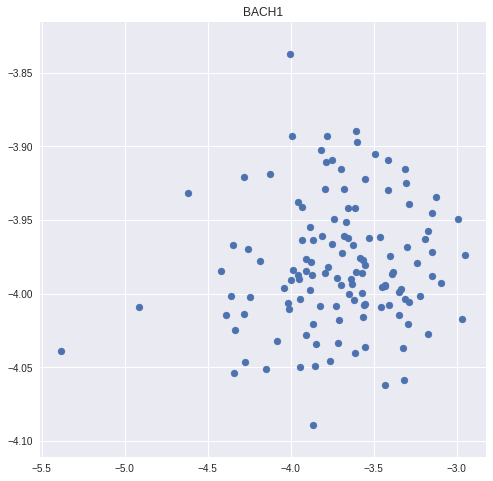

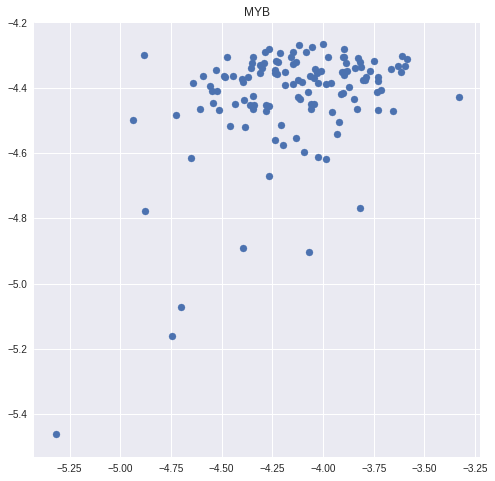

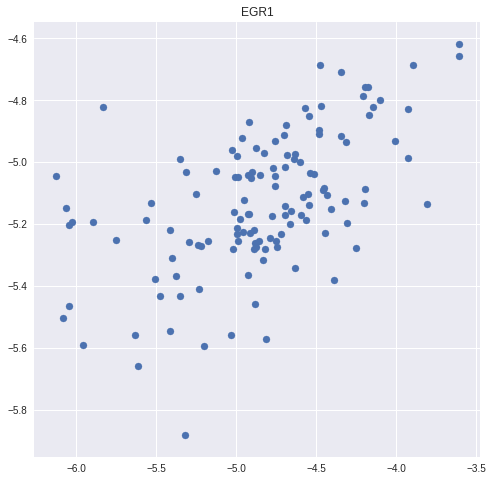

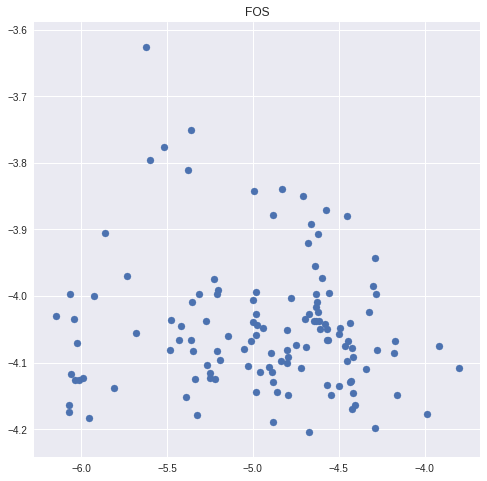

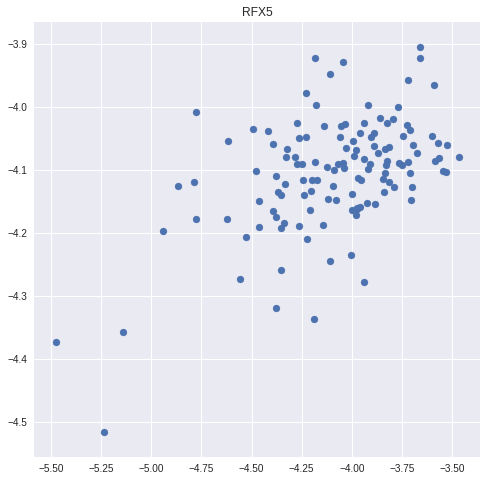

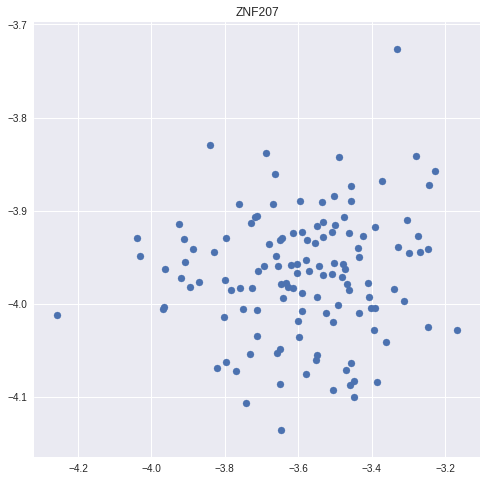

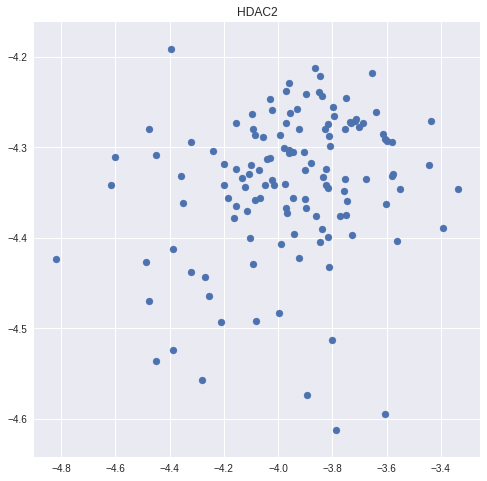

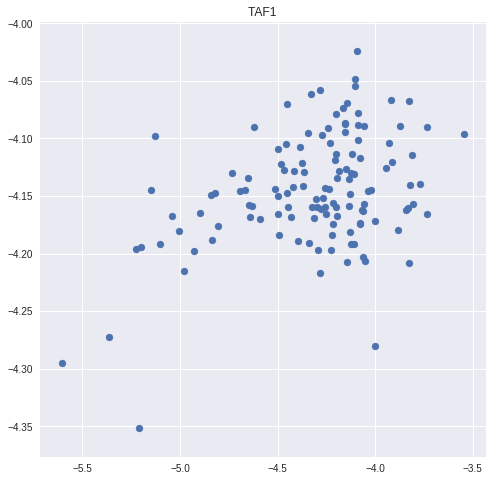

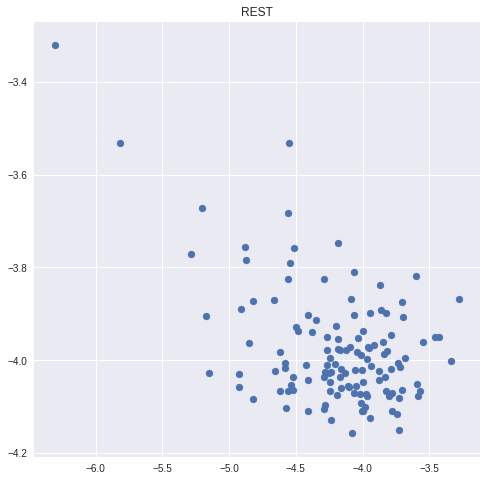

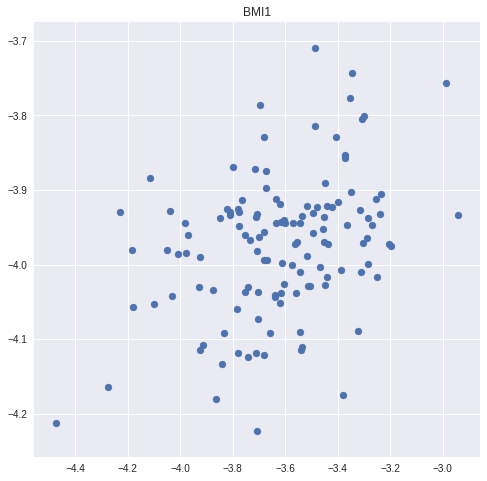

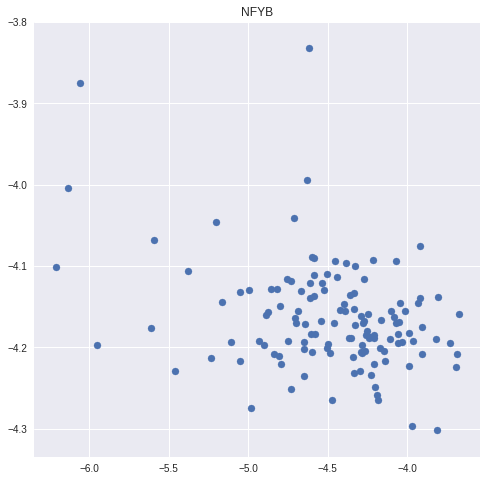

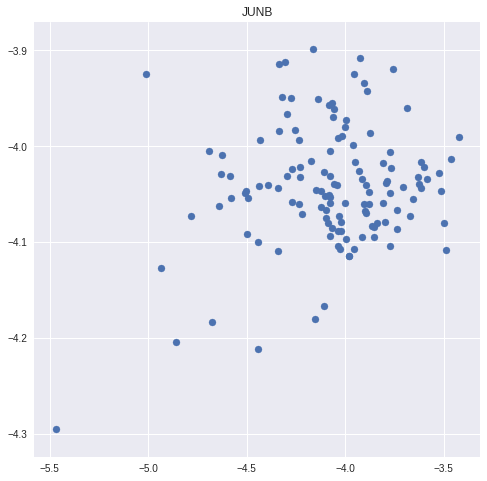

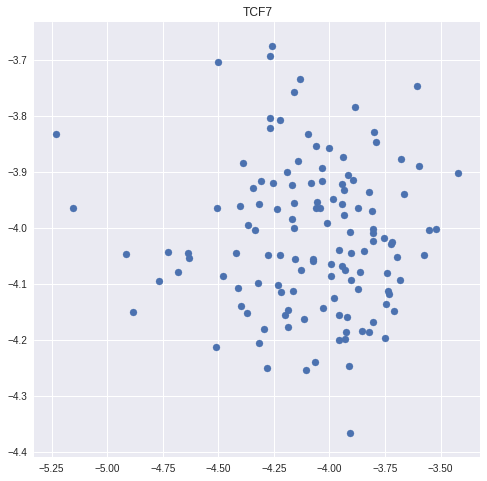

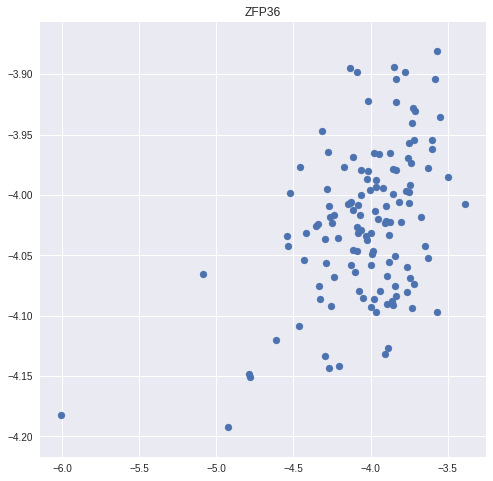

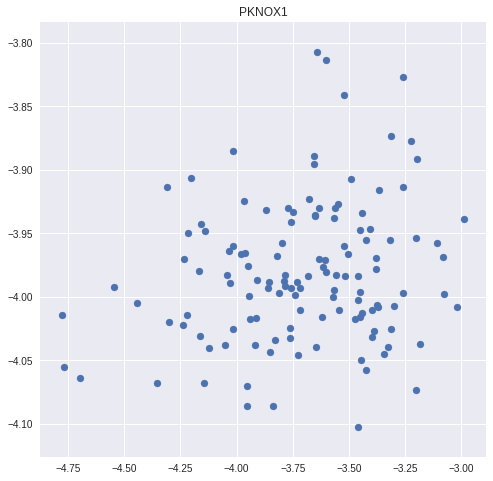

In [139]:
for i, n in enumerate(genelist):
    figure(figsize=(8, 8))
    scatter((log(bsm + 1) - m)[:, i], (log(psm + 1) - mp)[:, i])
    title(n)

In [113]:
print("\t".join(genelist))

MAFK	RAD21	MTA2	SMC3	USF2	CUX1	BHLHE40	RBBP5	ATF7	NFIC	MAZ	CREM	ZNF143	STAT3	ZBTB33	TRIM22	SUZ12	CBFB	STAT5A	ELF1	DPF2	SIX5	RB1	CTCF	BRCA1	RAD51	IRF4	EZH2	RCOR1	NFATC3	GATAD2B	MEF2B	TBP	RELB	E4F1	CEBPZ	NFE2	ZNF592	ZZZ3	ARNT	RELA	MAX	STAT1	SKIL	USF1	JUND	PAX8	CHD1	BCL3	FOXK2	SMARCA5	SMAD5	BATF	POLR3G	MLLT1	ETS1	E2F4	ASH2L	GABPA	ELK1	NRF1	NFYA	MTA3	EBF1	KLF5	IRF3	NR2C1	PBX3	RXRA	MEF2A	ESRRA	SPI1	HSF1	ETV6	WRNIP1	UBTF	ZNF217	HDAC6	TBL1XR1	NFXL1	ZNF687	CHD4	CBX3	NFATC1	ARID3A	CEBPB	ZEB1	SIN3A	ZNF384	CREB1	ZBED1	POLR2A	IKZF2	YBX1	EED	CBX5	ATF2	TCF12	NBN	EP300	SMAD1	SRF	ZNF622	RUNX3	IRF5	MYC	MEF2C	SP1	PAX5	TBX21	CHD2	E2F8	ZBTB40	IKZF1	HCFC1	HDGF	TARDBP	YY1	KDM1A	BCL11A	NR2F1	BCLAF1	NR2C2	MXI1	ZSCAN29	ZNF24	BACH1	MYB	EGR1	FOS	RFX5	ZNF207	HDAC2	TAF1	REST	BMI1	NFYB	JUNB	TCF7	ZFP36	PKNOX1
